In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statistics

%matplotlib inline
plt.style.reload_library()
plt.style.use(["science"])

# Graphing Helper Functions

In [2]:
def add_elapsed_column(df, shift=0):
    df["elapsed"] = (
        pd.to_datetime(df["_time"].values) - pd.to_datetime(df["_time"][0])
    ).total_seconds() + shift

def read_p95_csv(csv, shift=0):
    df_on_p95 = pd.read_csv(csv)[["_time", "_value", "_field"]]
    add_elapsed_column(df_on_p95, shift=shift)
    df_on_p95 = df_on_p95[df_on_p95["_field"] == "p95"]
    return df_on_p95

def read_pid_csv(csv, shift=0):
    df_on_pid = pd.read_csv(csv)[["_time", "_value", "_measurement"]]
    add_elapsed_column(df_on_pid, shift=shift)
    df_on_pid = df_on_pid[df_on_pid["_measurement"] == "dimmer_output"]
    return df_on_pid

def print_stats(df_on_p95, df_on_pid):
    print("p95 mean: ", statistics.mean(df_on_p95[df_on_p95["elapsed"].between(100, 1810)]["_value"].values))
    print("p95 stdev: ", statistics.pstdev(df_on_p95[df_on_p95["elapsed"].between(100, 1810)]["_value"].values))
    print("pid output mean: ", statistics.mean(df_on_pid[df_on_pid["elapsed"].between(100, 1810)]["_value"].values))
    print("pid output stdev: ", statistics.pstdev(df_on_pid[df_on_pid["elapsed"].between(100, 1810)]["_value"].values))

def remove_spikes(df):
    # Clean up spikes at end of run
    for elapsed_with_zero_value in df.loc[df["_value"] == 0]["elapsed"].values:
        df = df.drop(
            df.loc[
                (df["elapsed"] >= elapsed_with_zero_value - 10)
                & (df["elapsed"] <= elapsed_with_zero_value)
            ].index
        )
    return df

def experiment_start_points(df):
    zero_points = df.loc[df["_value"] == 0]["elapsed"].values.tolist()
    output = []
    for zero_point in zero_points:
        if not any(zero_point > p - 20 and zero_point < p + 20 for p in output):
            output.append(zero_point)
    return output[1:]

def scaffold_p95_pid_graph(xlim, ylim, figsize, dpi):
    plt.rcParams["figure.figsize"] = figsize
    plt.rcParams["figure.dpi"] = dpi

    fig, ax1 = plt.subplots()

    ax1.set_xlabel("Time (seconds)")
    ax1.set_ylabel("Response time (seconds)")
    ax1.set_xlim([0, xlim])
    ax1.set_ylim([0, ylim])
    plt.axhline(y=3, color='black', linestyle='--', linewidth=0.5)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    ax2.set_ylabel("PID output (\%)")  # we already handled the x-label with ax1
    ax2.set_ylim([0, 100])

    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    return ax1, ax2, fig


def plot_p95_pid_graph(df_on_p95, df_on_pid, ylim, xlim=1080, legend_bbox=(0.905, 0.9),
    figsize=None, dpi=400):
    if figsize is None:
        figsize = [8, 3]

    ax1, ax2, fig = scaffold_p95_pid_graph(xlim, ylim, figsize, dpi)

    line1 = ax1.plot(df_on_p95["elapsed"].values, df_on_p95["_value"].values, color="#4477AA")
    line2 = ax2.plot(df_on_pid["elapsed"].values, df_on_pid["_value"].values, color="#66CCEE")

    fig.legend(
        ["Setpoint", "Response time", "PID output"],
        frameon=True,
        loc="upper right",
        bbox_to_anchor=legend_bbox,
    )

def plot_dotted_verticals(points):
    for xc in points:
        plt.axvline(x=xc, color="k", linestyle="--", linewidth=0.5)

# Load Shapes

## Flash Crowd

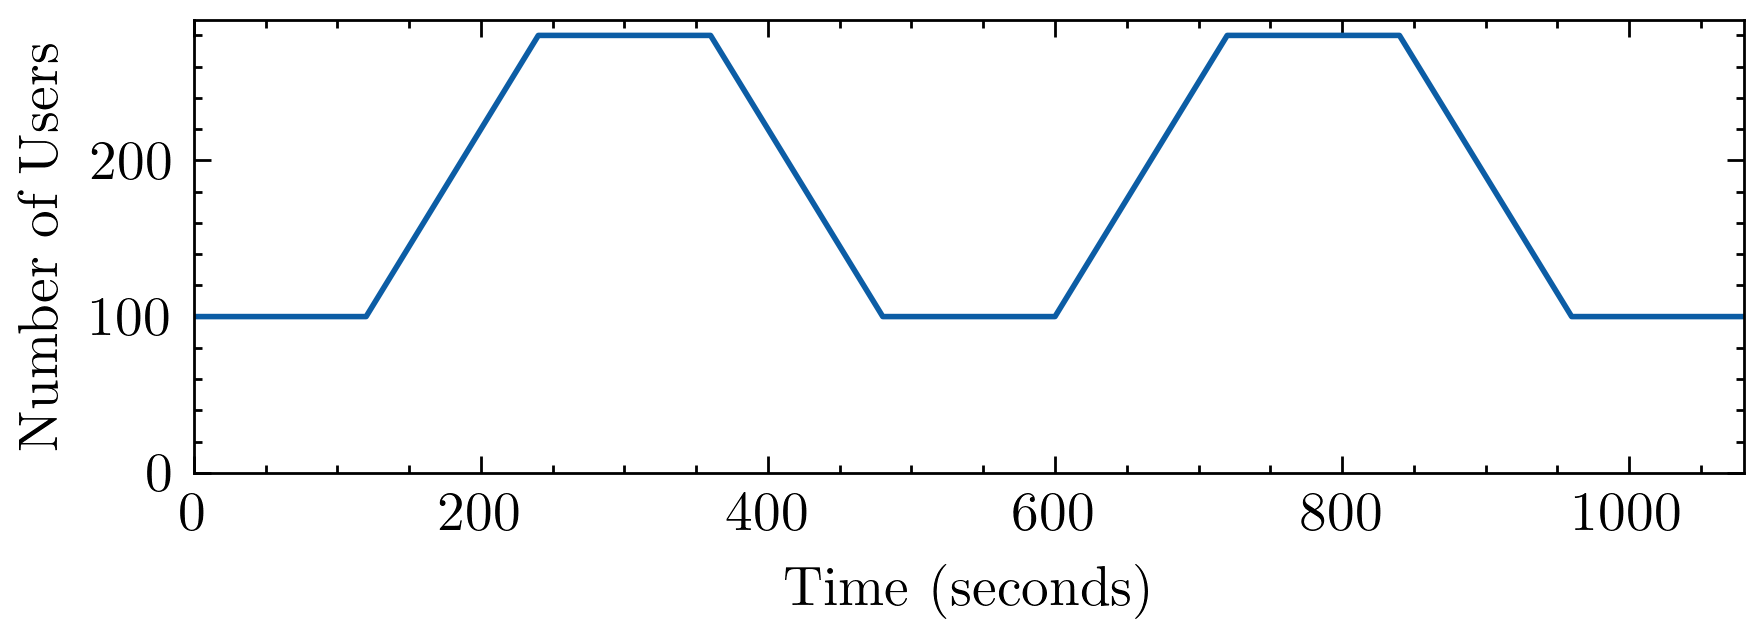

In [3]:
plt.rcParams["figure.figsize"] = [5, 1.5]
plt.rcParams["figure.dpi"] = 400

plt.figure()
plt.plot(
    [0, 120, 240, 360, 480, 600, 720, 840, 960, 1080],
    [100, 100, 280, 280, 100, 100, 280, 280, 100, 100],
)
plt.xlabel("Time (seconds)")
plt.ylabel("Number of Users")

plt.xlim([0, 1080])
plt.ylim([0, 290])
plt.savefig("../out/flash_crowd.pdf")

# Saturation Experiments

## Finding the saturation when dimming is disabled

In [4]:
df = pd.read_csv(
    "data/saturation_dimming_disabled_p95_2021-05-09-21-45_chronograf_data.csv"
)[["_time", "_value"]]
df["elapsed"] = (
    pd.to_datetime(df["_time"].values) - pd.to_datetime(df["_time"][0])
).total_seconds()

# Clean up spikes at end of run
for elapsed_with_zero_value in df.loc[df["_value"] == 0]["elapsed"].values:
    df.drop(
        df.loc[
            (df["elapsed"] >= elapsed_with_zero_value - 15)
            & (df["elapsed"] <= elapsed_with_zero_value)
        ].index,
        inplace=True,
    )

df.head()

_time    _value   elapsed
0  2021-05-09T16:10:58.839973549Z  0.174222  0.000000
1  2021-05-09T16:10:59.839940444Z  0.210537  0.999967
2  2021-05-09T16:11:00.839448659Z  0.208734  1.999475
3  2021-05-09T16:11:01.840023331Z  0.210044  3.000050
4   2021-05-09T16:11:02.83984928Z  0.210044  3.999876

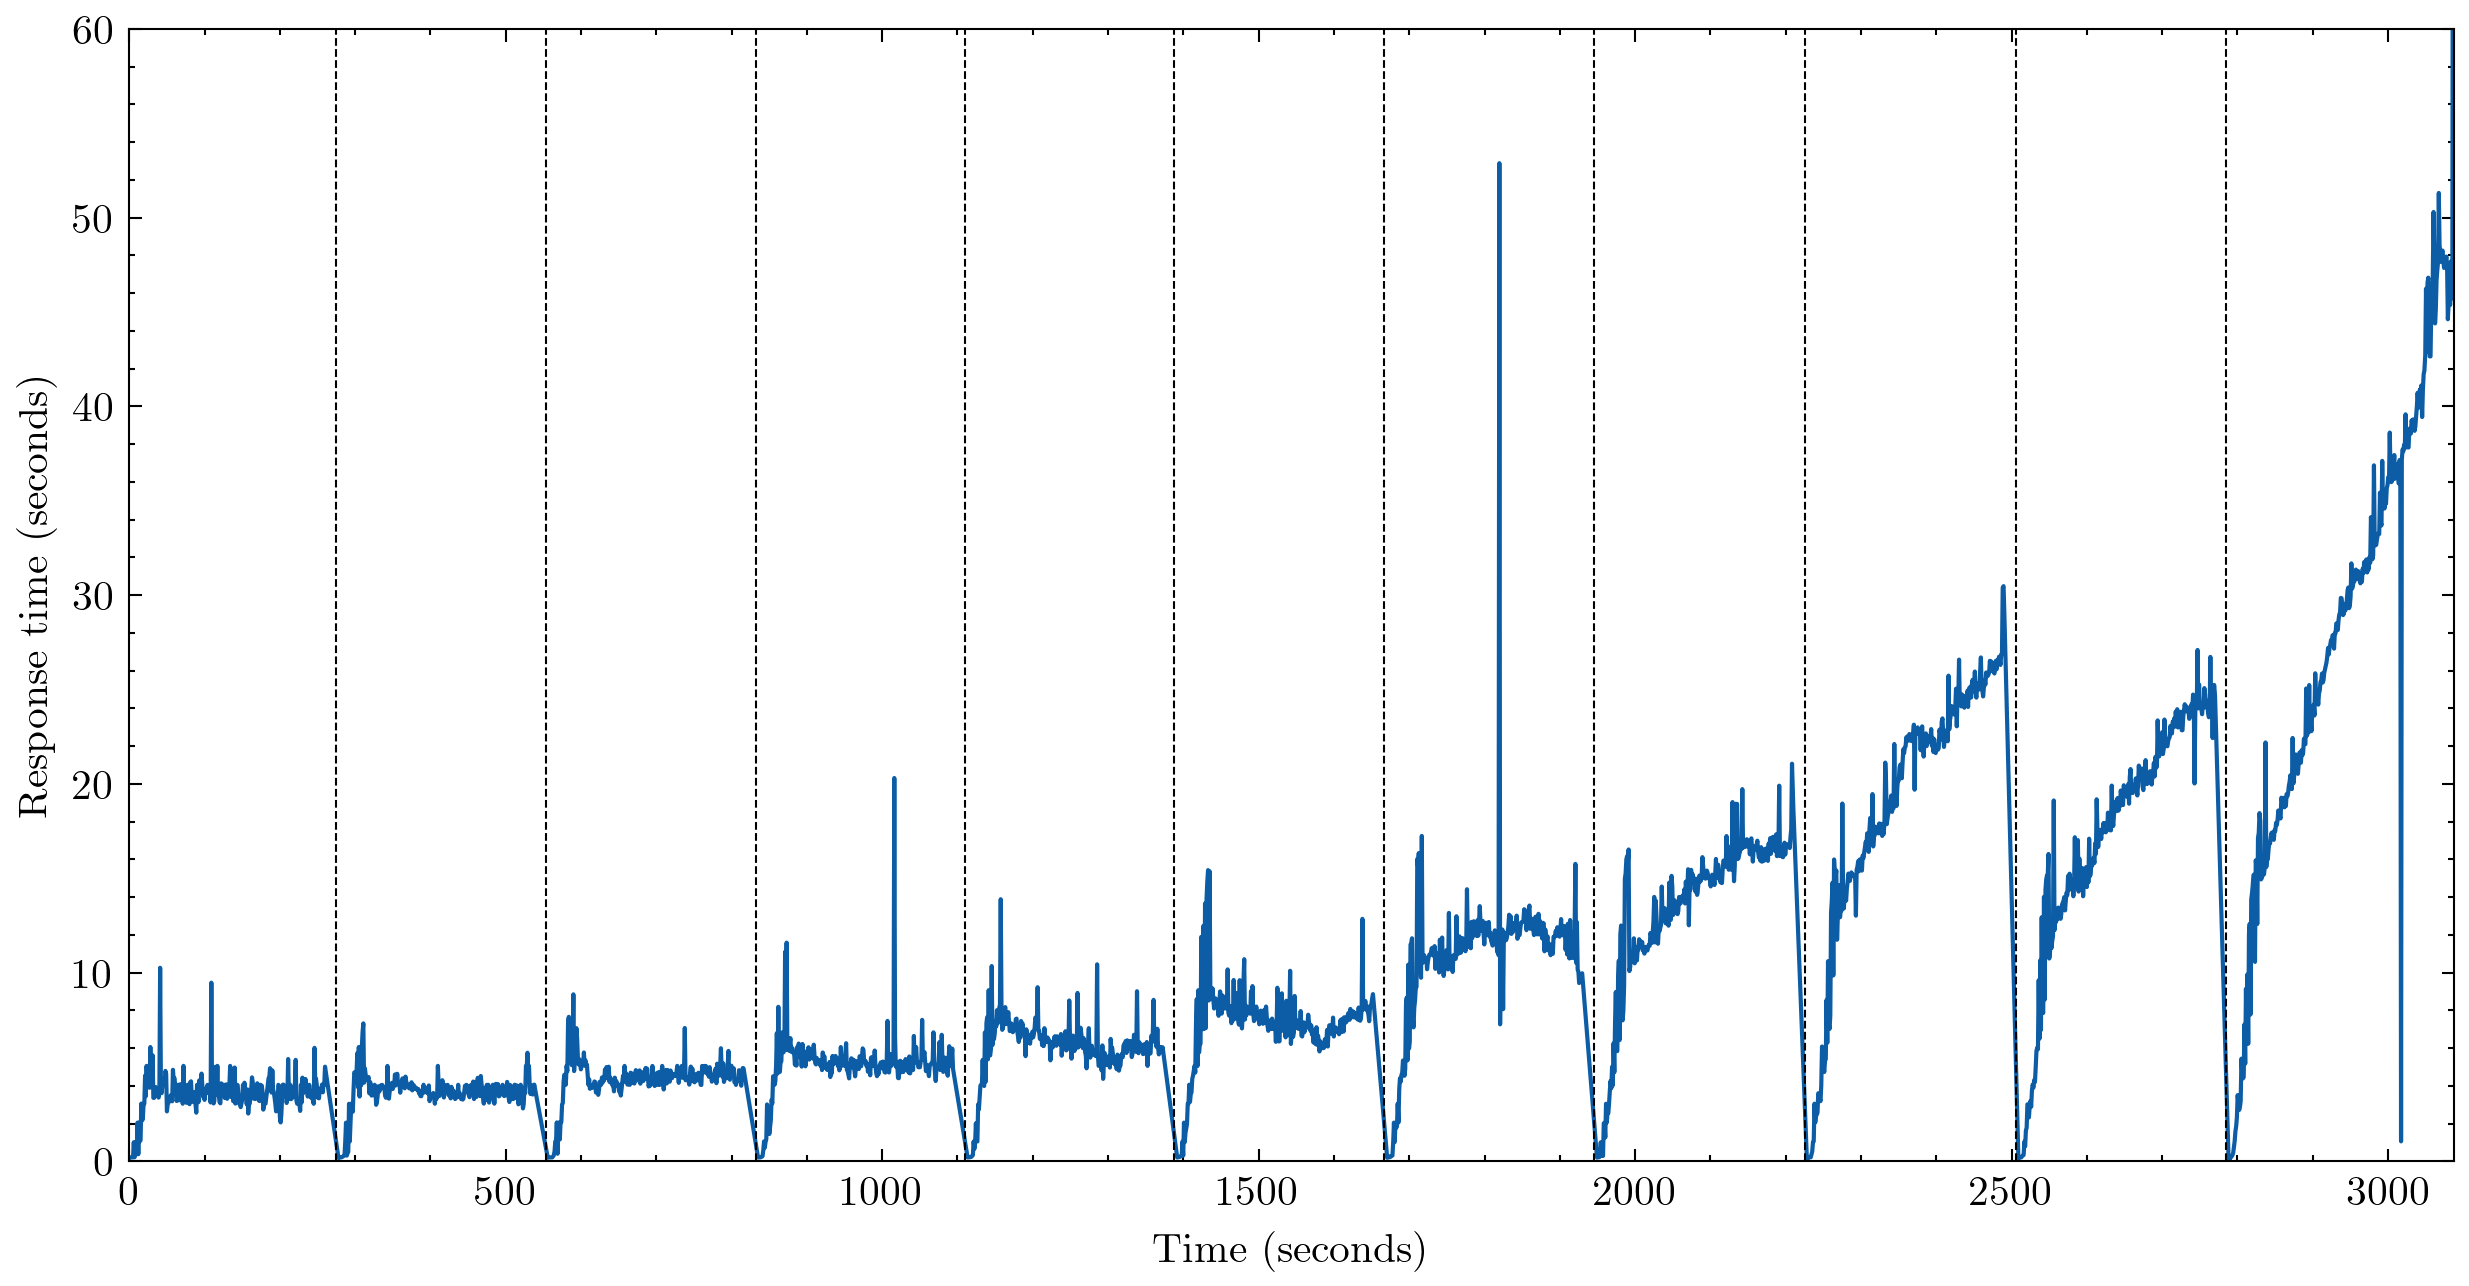

In [5]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.dpi"] = 300

plt.figure()
plt.plot(df["elapsed"].values, df["_value"].values)

plt.xlabel("Time (seconds)")
plt.ylabel("Response time (seconds)")

plt.xlim([0, 3088])
plt.ylim([0, 60])

xposition = [275, 553, 832, 1110, 1388, 1667, 1946, 2225, 2506, 2785]
for xc in xposition:
    plt.axvline(x=xc, color="k", linestyle="--", linewidth=0.5)
plt.savefig("../out/dimming_disabled_saturation.pdf")

## Finding the saturation when dimming is enabled

In [6]:
df = pd.read_csv(
    "data/saturation_dimming_enabled_p95_2021-05-10-10-31_chronograf_data.csv"
)[["_time", "_value"]]
df["elapsed"] = (
    pd.to_datetime(df["_time"].values) - pd.to_datetime(df["_time"][0])
).total_seconds()

# Clean up spikes at end of run
for elapsed_with_zero_value in df.loc[df["_value"] == 0]["elapsed"].values:
    df.drop(
        df.loc[
            (df["elapsed"] >= elapsed_with_zero_value - 15)
            & (df["elapsed"] <= elapsed_with_zero_value)
        ].index,
        inplace=True,
    )

df.tail()

_time     _value      elapsed
3601  2021-05-09T21:39:18.214283212Z   3.214504  3617.824673
3602  2021-05-09T21:39:19.214097471Z   2.051742  3618.824487
3603  2021-05-09T21:39:20.214552465Z   6.240665  3619.824942
3604  2021-05-09T21:39:21.342086783Z  10.264084  3620.952476
3605  2021-05-09T21:39:22.342124906Z  11.234368  3621.952515

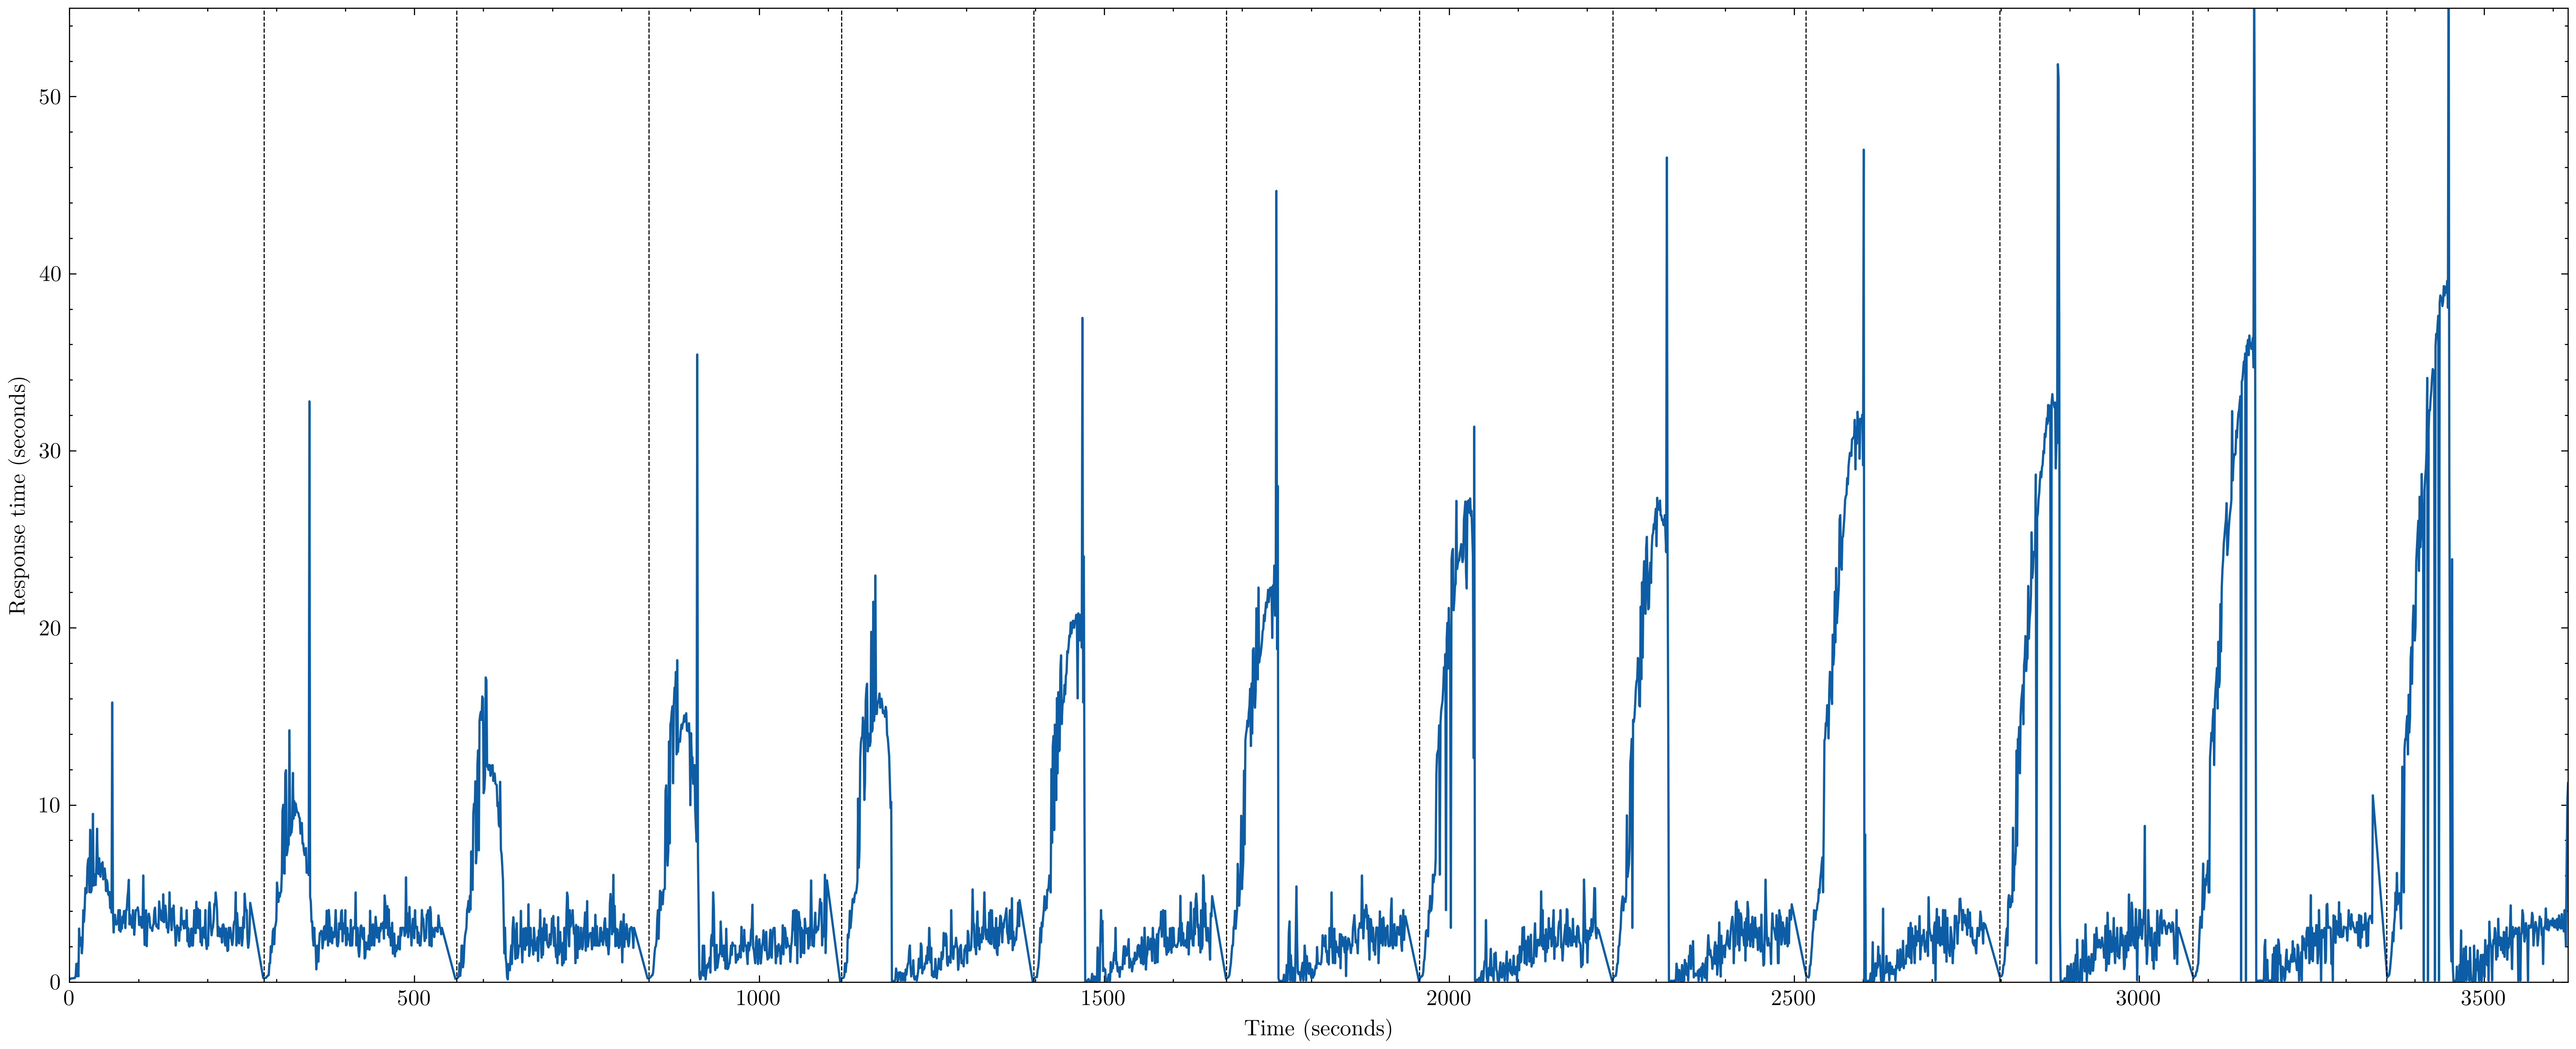

In [7]:
plt.rcParams["figure.figsize"] = [20, 8]
plt.rcParams["figure.dpi"] = 400

plt.figure()
plt.plot(df["elapsed"].values, df["_value"].values)

plt.xlabel("Time (seconds)")
plt.ylabel("Response time (seconds)")

plt.xlim([0, 3622])
plt.ylim([0, 55])

xposition = [282, 561, 840, 1119, 1398, 1677, 1957, 2237, 2517, 2798, 3078, 3359]
for xc in xposition:
    plt.axvline(x=xc, color="k", linestyle="--", linewidth=0.5)
plt.savefig("../out/dimming_enabled_saturation.pdf")

# Evaluation Experiments

## Baseline Dimming: Adaptive Control Behaviour

### Constant Load, Dimmer On

p95 mean:  2.9668294712264704
p95 stdev:  0.7428892928473317
pid output mean:  46.85524210266933
pid output stdev:  1.6271824050639367


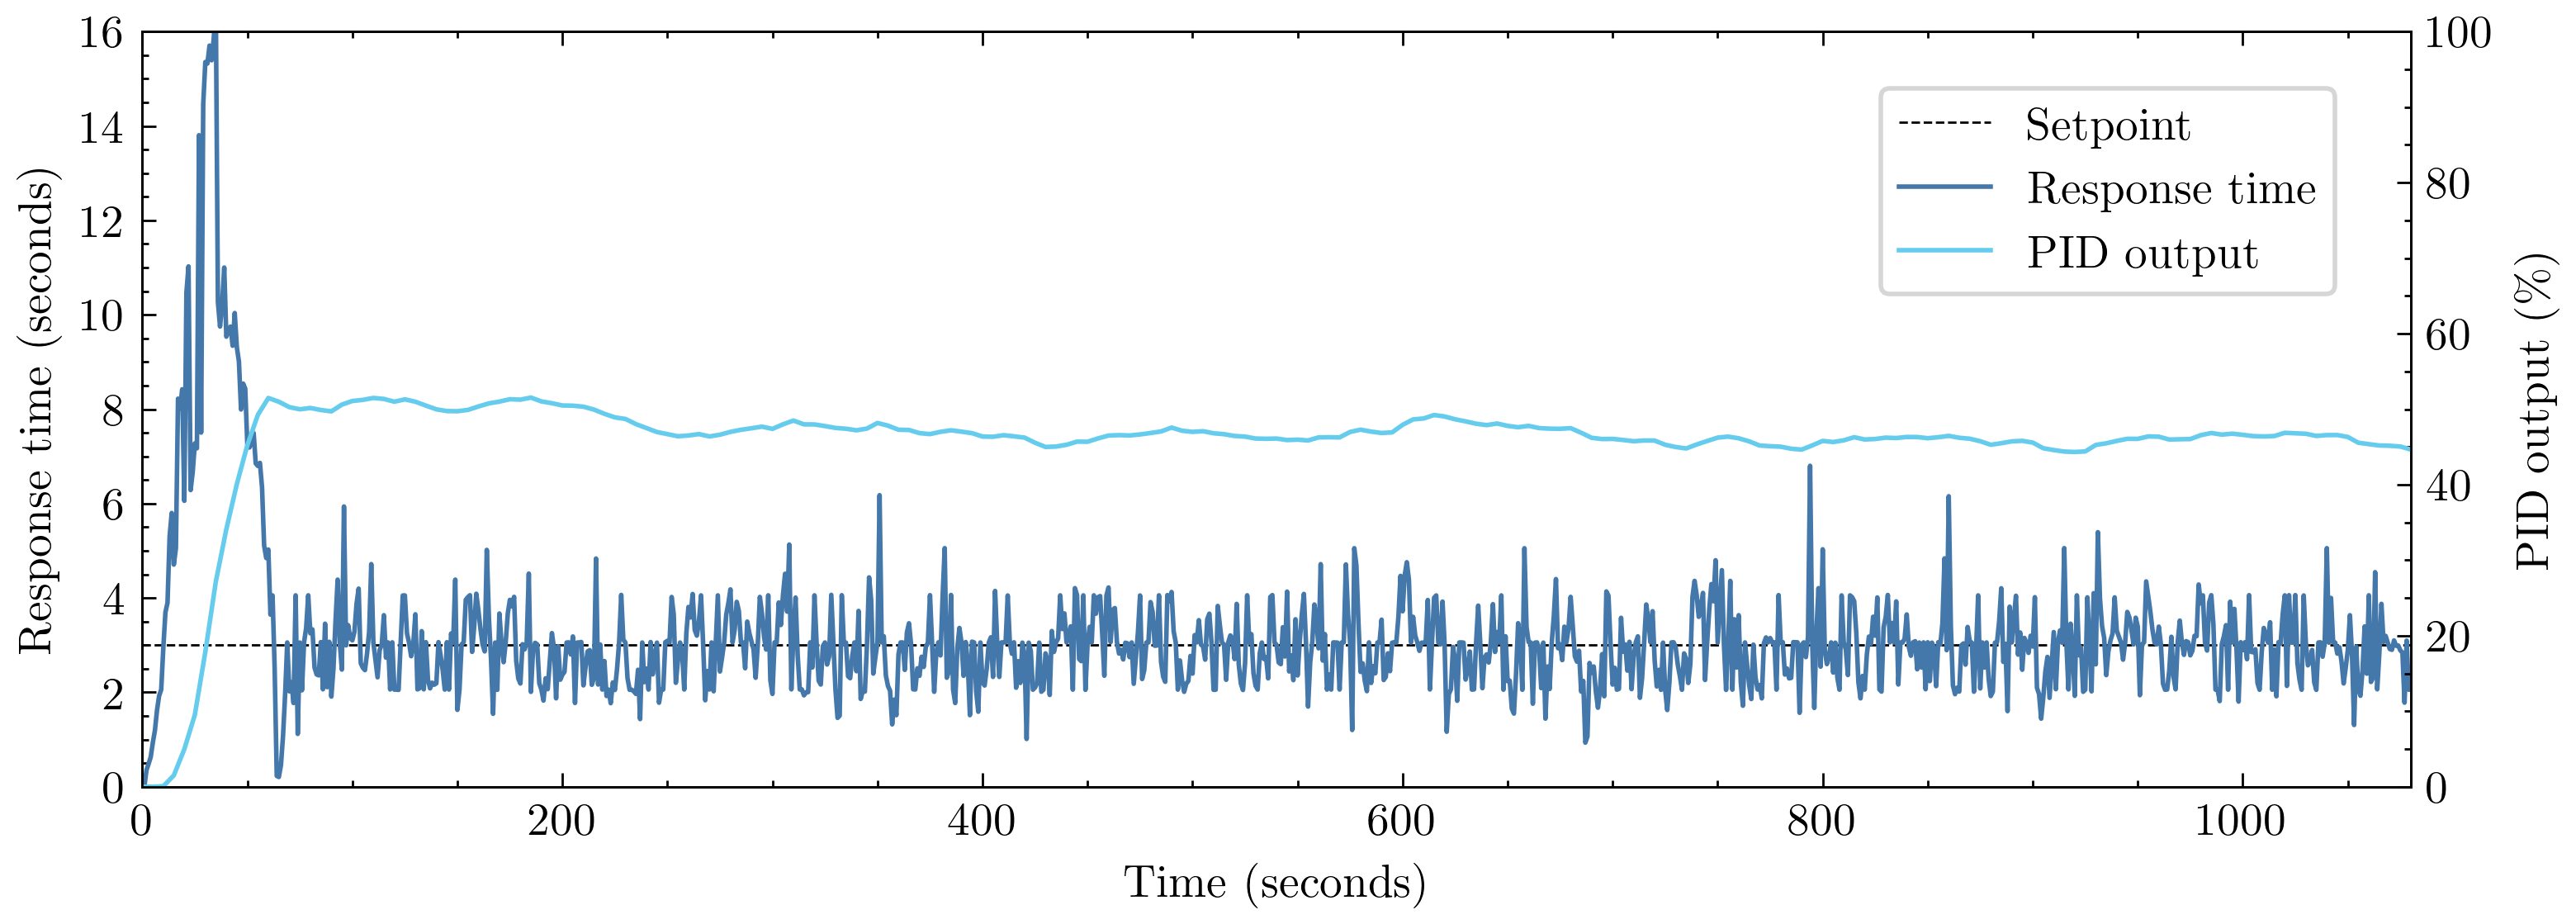

In [8]:
p95_csv = "data/constant_load_p95_2021-05-10-12-14_chronograf_data.csv"
pid_csv = "data/constant_load_pid_chronograf_data.csv"
out = "../out/baseline_dimming_adaptive_control_dimmer_on.pdf"

df_on_p95 = pd.read_csv(p95_csv)[["_time", "_value"]]
add_elapsed_column(df_on_p95)
df_on_pid = read_pid_csv(pid_csv)

print_stats(df_on_p95, df_on_pid)
plot_p95_pid_graph(df_on_p95, df_on_pid, ylim=16)
plt.savefig(out)

### Constant Load, Dimmer Off

p95 mean:  5.248158413023392
p95 stdev:  1.1495940775629128


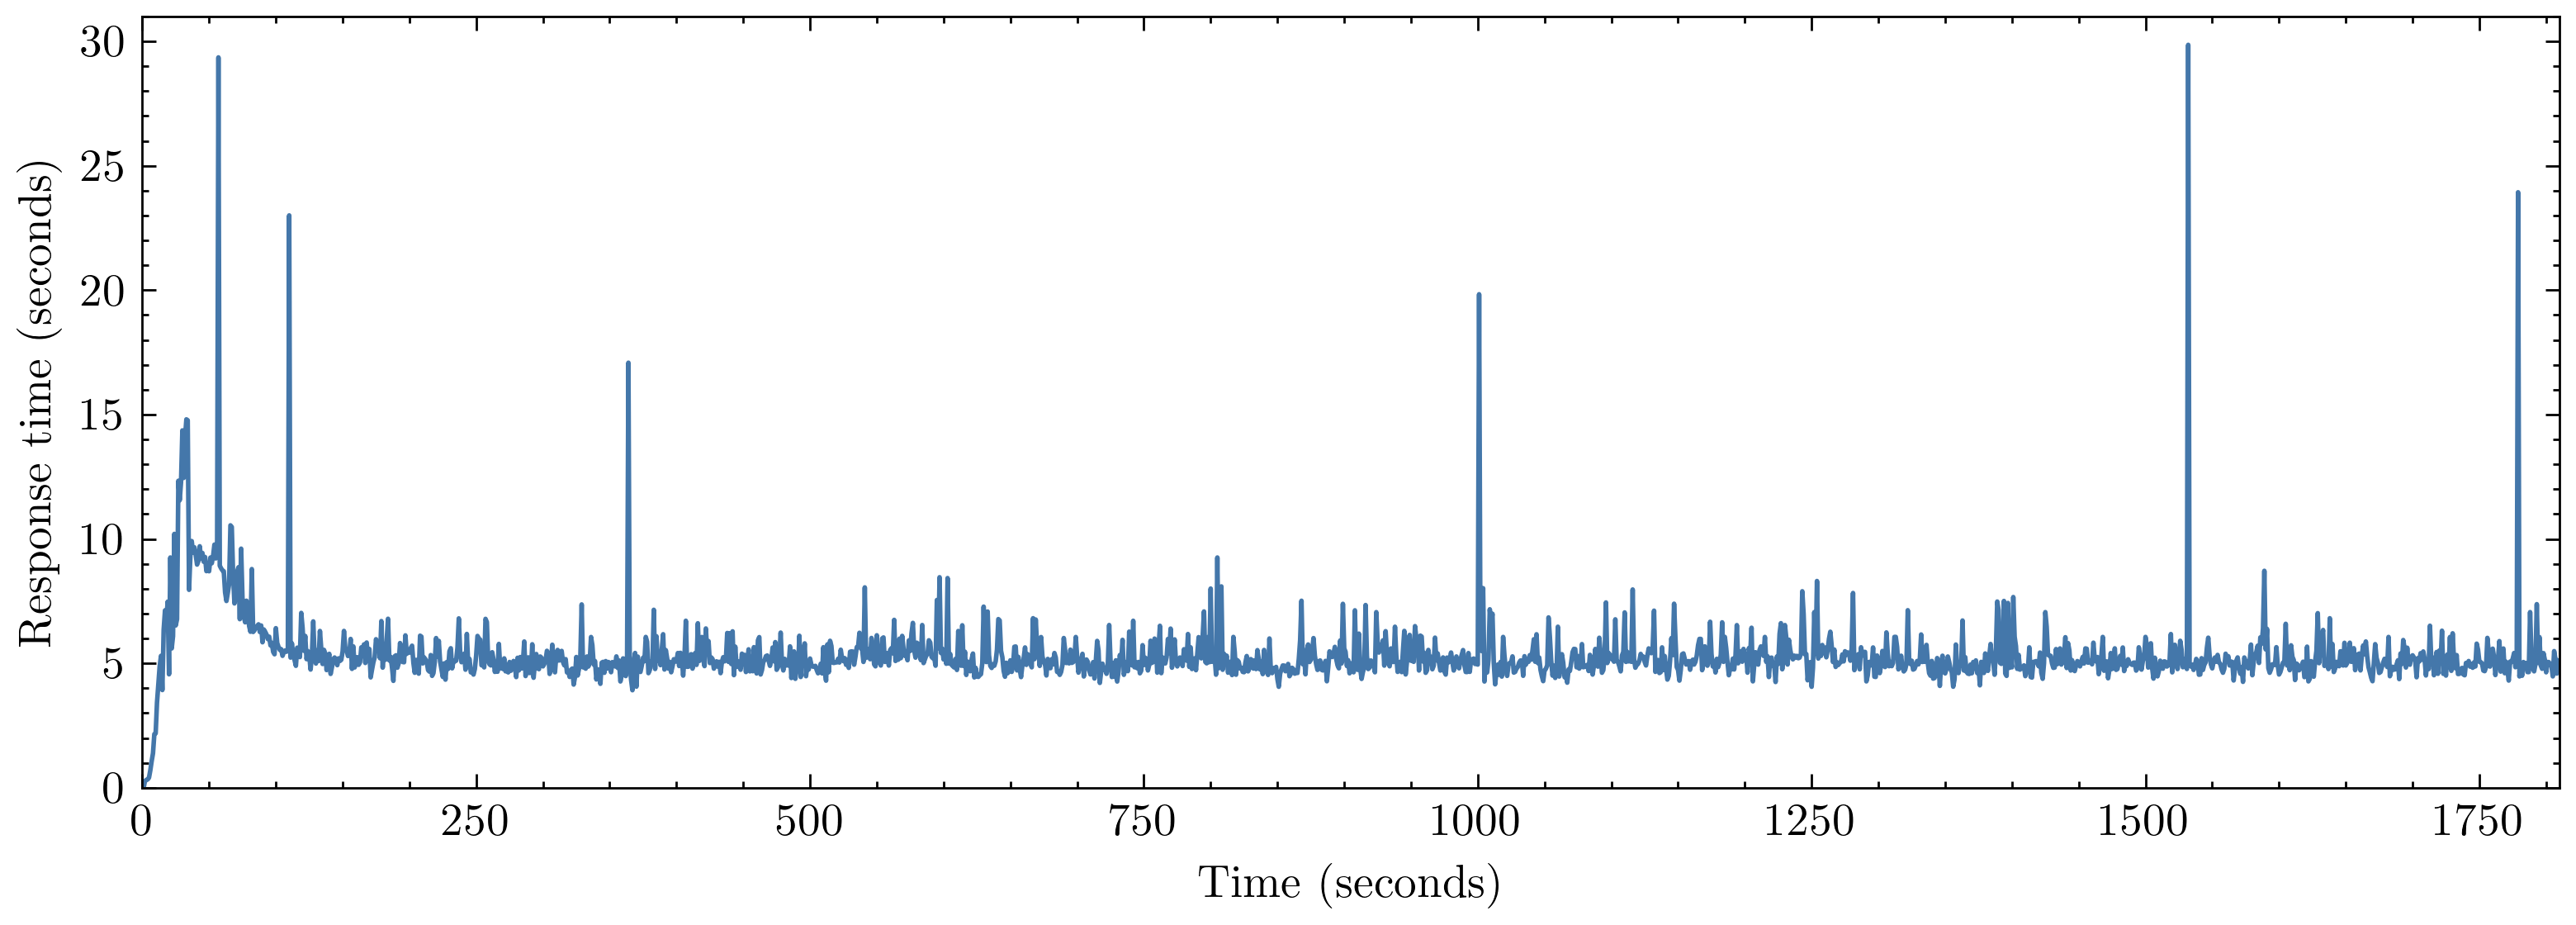

In [9]:
p95_csv = "data/constant_load_disabled_p95_2021-05-13-17-04_chronograf_data.csv"
out = "../out/baseline_dimming_adaptive_control_dimmer_off.pdf"

df_on_p95 = pd.read_csv(p95_csv)[["_time", "_value"]]
add_elapsed_column(df_on_p95)

print("p95 mean: ", statistics.mean(df_on_p95[df_on_p95["elapsed"].between(100, 1810)]["_value"].values))
print("p95 stdev: ", statistics.pstdev(df_on_p95[df_on_p95["elapsed"].between(100, 1810)]["_value"].values))

plt.rcParams["figure.figsize"] = [8, 3]
plt.rcParams["figure.dpi"] = 400

fig, ax1 = plt.subplots()

color = "#4477AA"
ax1.set_xlabel("Time (seconds)")
ax1.set_ylabel("Response time (seconds)")
line1 = ax1.plot(df_on_p95["elapsed"].values, df_on_p95["_value"].values, color=color)
ax1.set_xlim([0, 1810])
ax1.set_ylim([0, 31])

fig.tight_layout()  # otherwise the right y-label is slightly clipped

# fig.legend(["Response time", "PID output"], frameon=True, loc='upper right', bbox_to_anchor=(0.905,0.9))
plt.savefig(out)

### Flash Crowd, Dimmer On

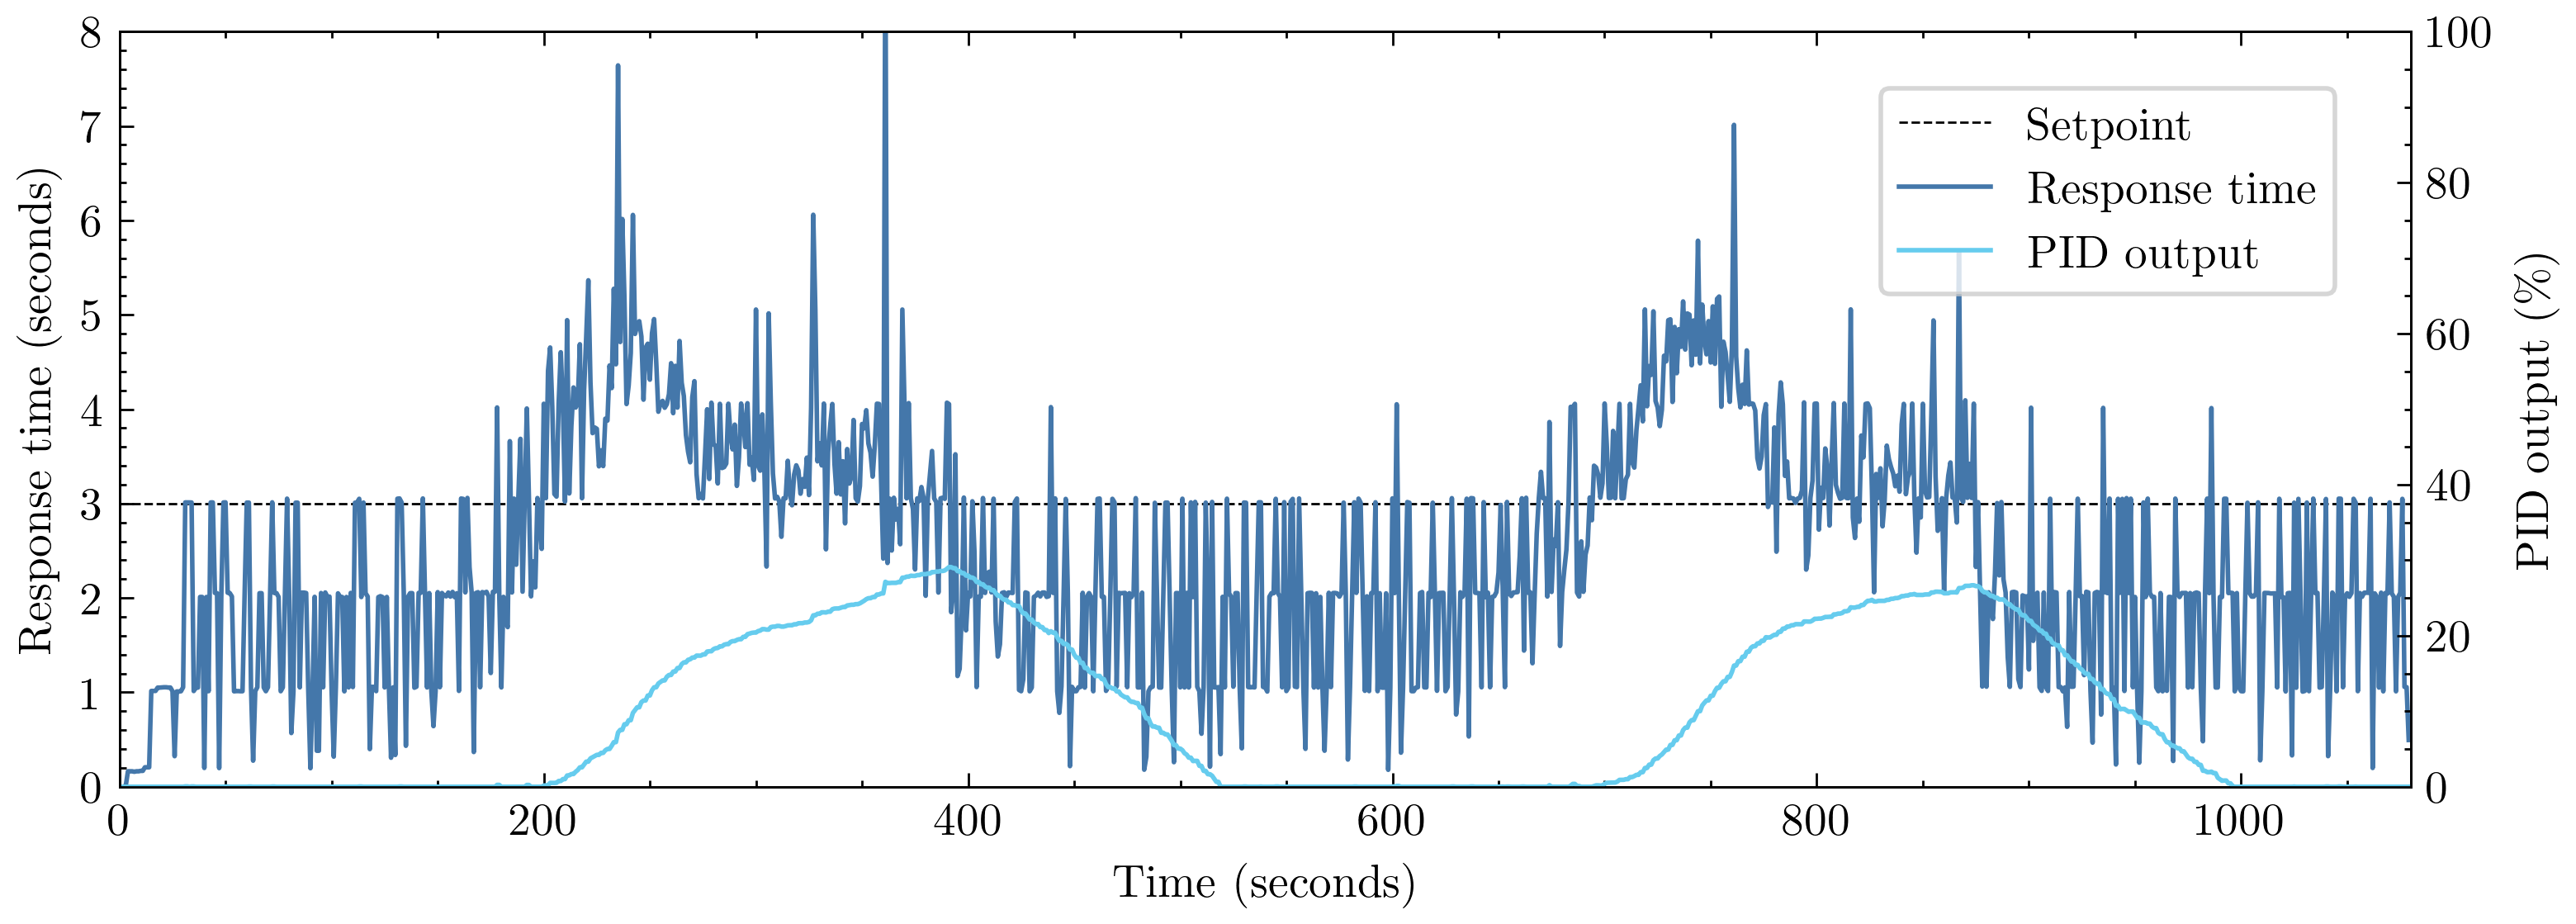

In [10]:
p95_csv = "data/flash_crowd_2021-05-13-19-27_chronograf_data.csv"
out = "../out/baseline_dimming_adaptive_control_flash_crowd_dimmer_on.pdf"

df_on_p95 = read_p95_csv(p95_csv)

df_on_pid = pd.read_csv("data/flash_crowd_2021-05-13-19-27_chronograf_data.csv")[
    ["_time", "_value", "_measurement"]
]
add_elapsed_column(df_on_pid)
df_on_pid = df_on_pid[df_on_pid["_measurement"] == "dimmer_output"]

plot_p95_pid_graph(df_on_p95, df_on_pid, ylim=8)
plt.savefig(out)

## Component weightings dimming

p95 mean:  2.986523185395906
p95 stdev:  0.7069327025484651
pid output mean:  36.6275842006306
pid output stdev:  1.669491305669959


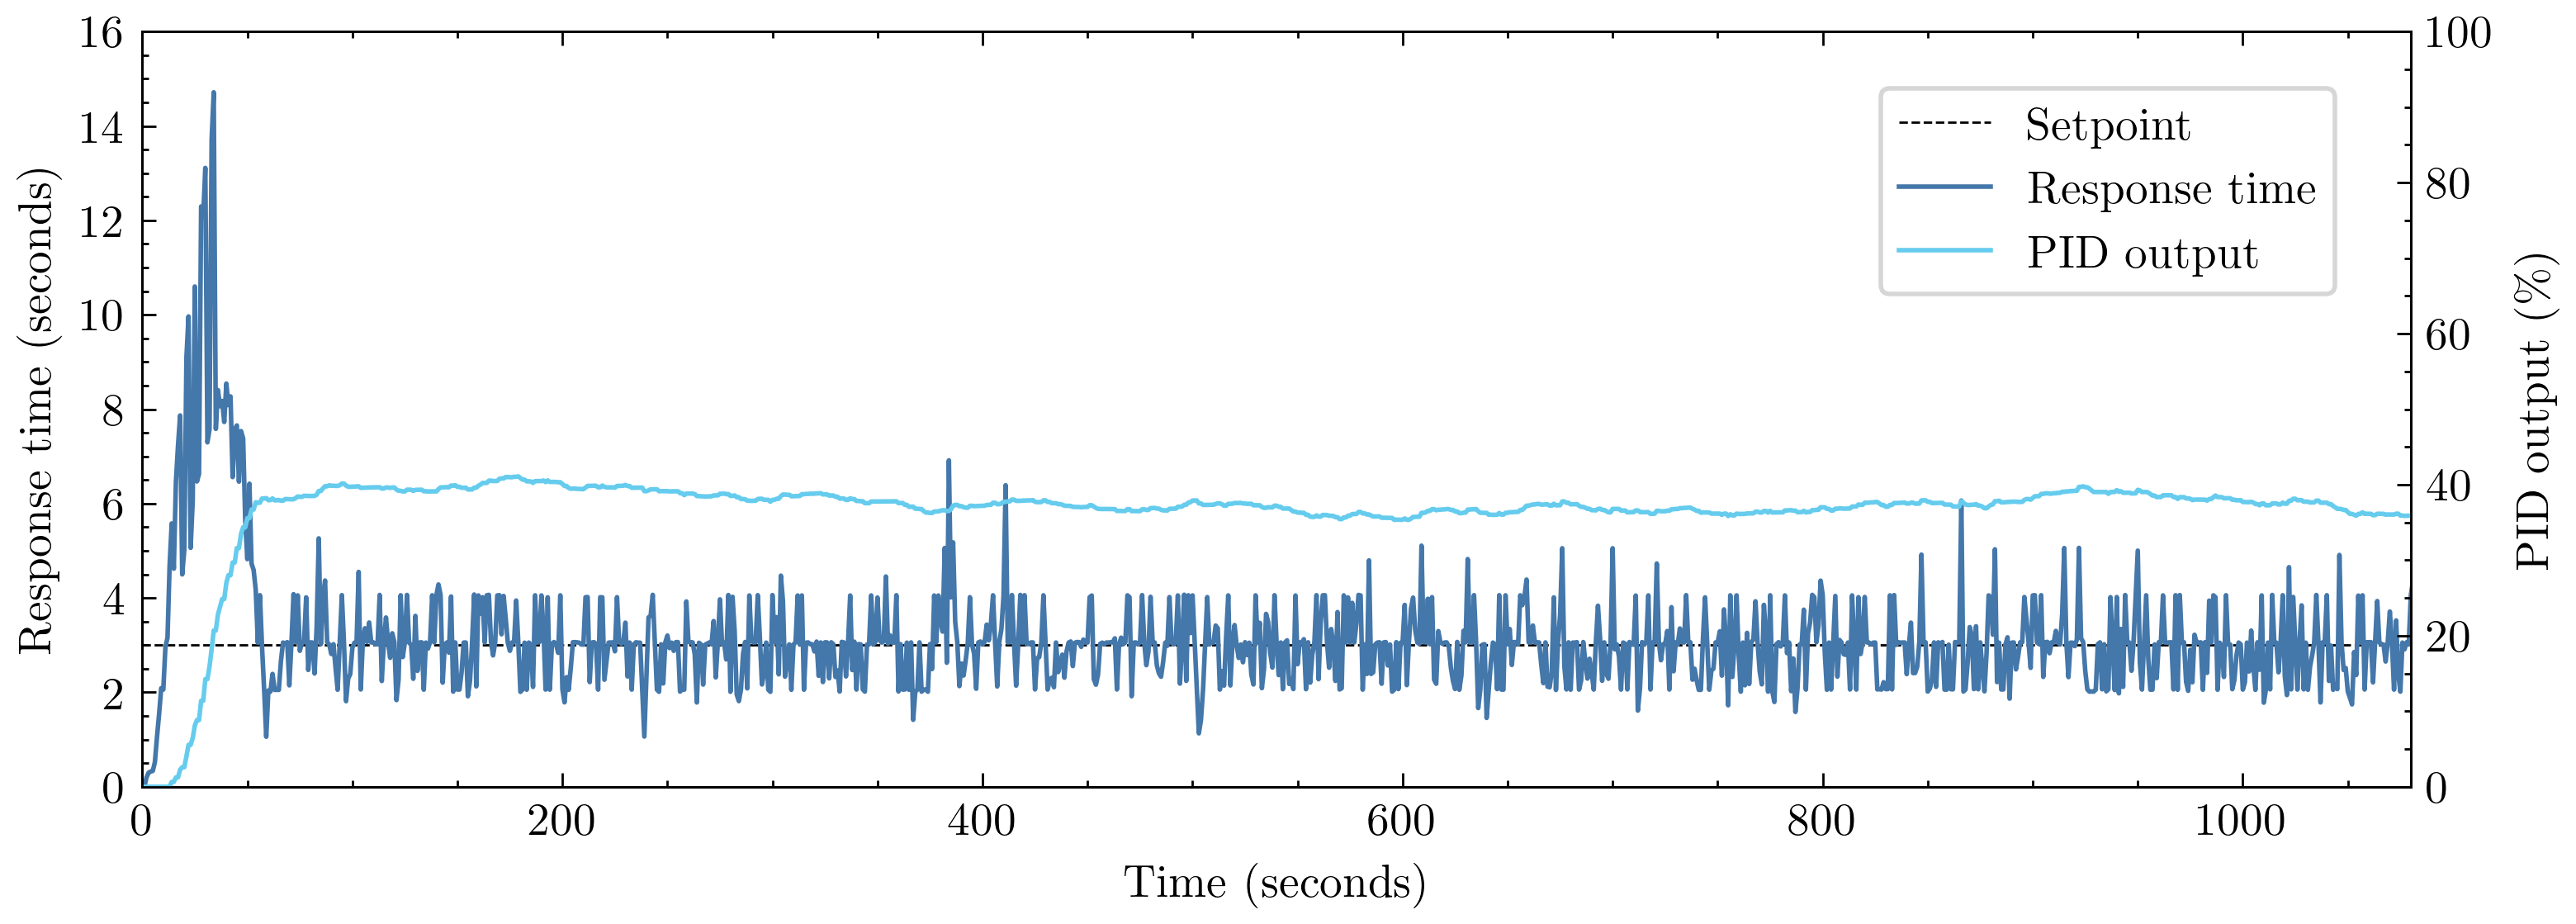

In [11]:
p95_csv = "data/constant_load_repeats_weightings_repeats_response_times_2021-05-11-15-06_chronograf_data.csv"
pid_csv = "data/constant_load_repeats_weightings_repeats_pid_output_2021-05-11-15-07_chronograf_data.csv"
out = "../out/component_weightings_dimming.pdf"

df_on_p95 = read_p95_csv(p95_csv)
df_on_pid = read_pid_csv(pid_csv)

print_stats(df_on_p95, df_on_pid)
plot_p95_pid_graph(df_on_p95, df_on_pid, ylim=16)
plt.savefig(out)


## Profiling dimming (no component weightings)

p95 mean:  2.965058851907602
p95 stdev:  0.7167733963405023
pid output mean:  37.591473032391605
pid output stdev:  2.2597408120493463


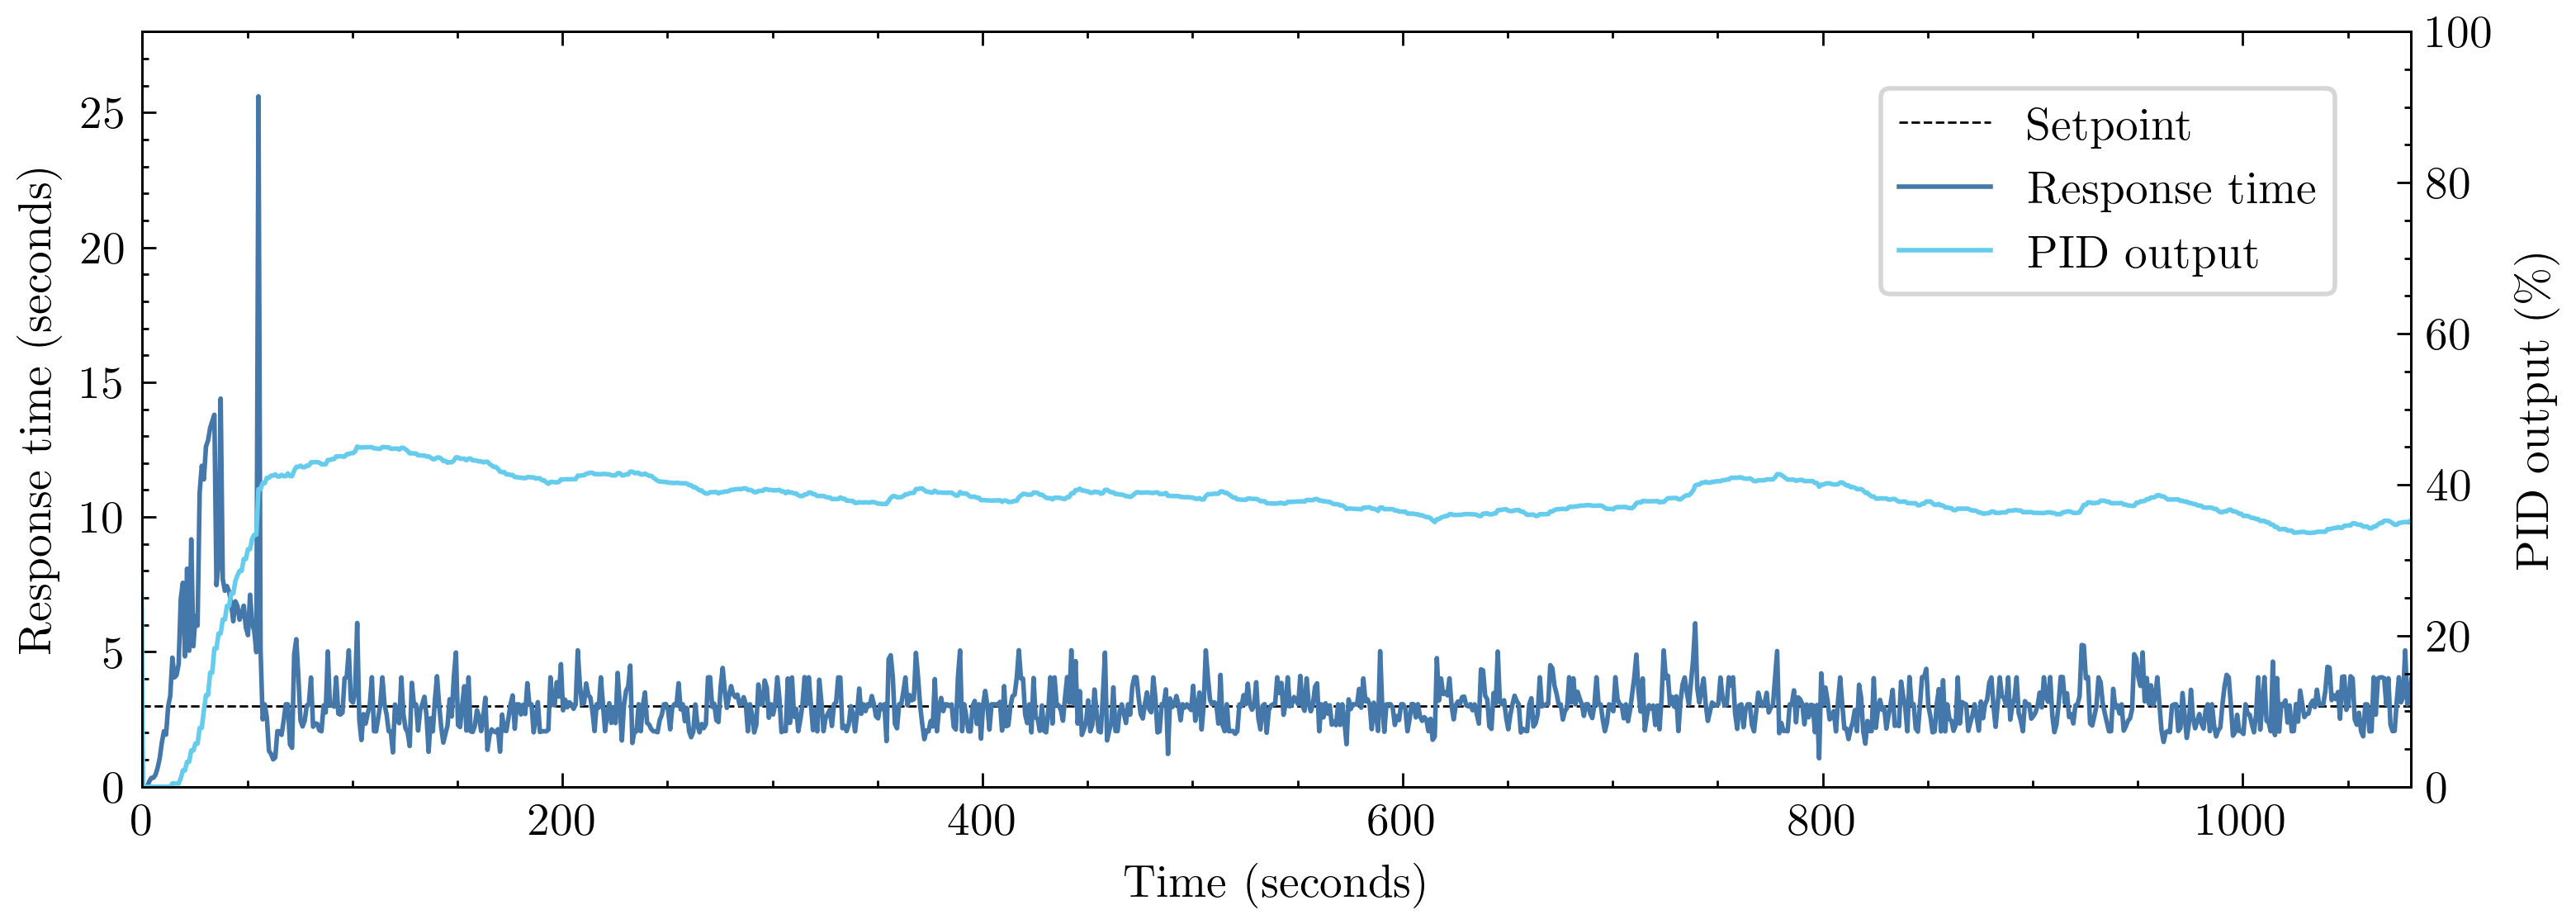

In [12]:
# We accidentally exported 81 seconds too early of data which we want to hide from graphs.
FALSE_START_SHIFT = -81

p95_csv = "data/constant_load_repeats_profiling_response_times_2021-05-12-15-30_chronograf_data.csv"
pid_csv = "data/constant_load_repeats_profiling_pid_output_2021-05-12-15-29_chronograf_data.csv"
out = "../out/profiling_dimming_without_component_weightings.pdf"

df_on_p95 = read_p95_csv(p95_csv, shift=FALSE_START_SHIFT)
df_on_pid = read_pid_csv(pid_csv, FALSE_START_SHIFT)

print_stats(df_on_p95, df_on_pid)
plot_p95_pid_graph(df_on_p95, df_on_pid, ylim=28)
plt.savefig(out)

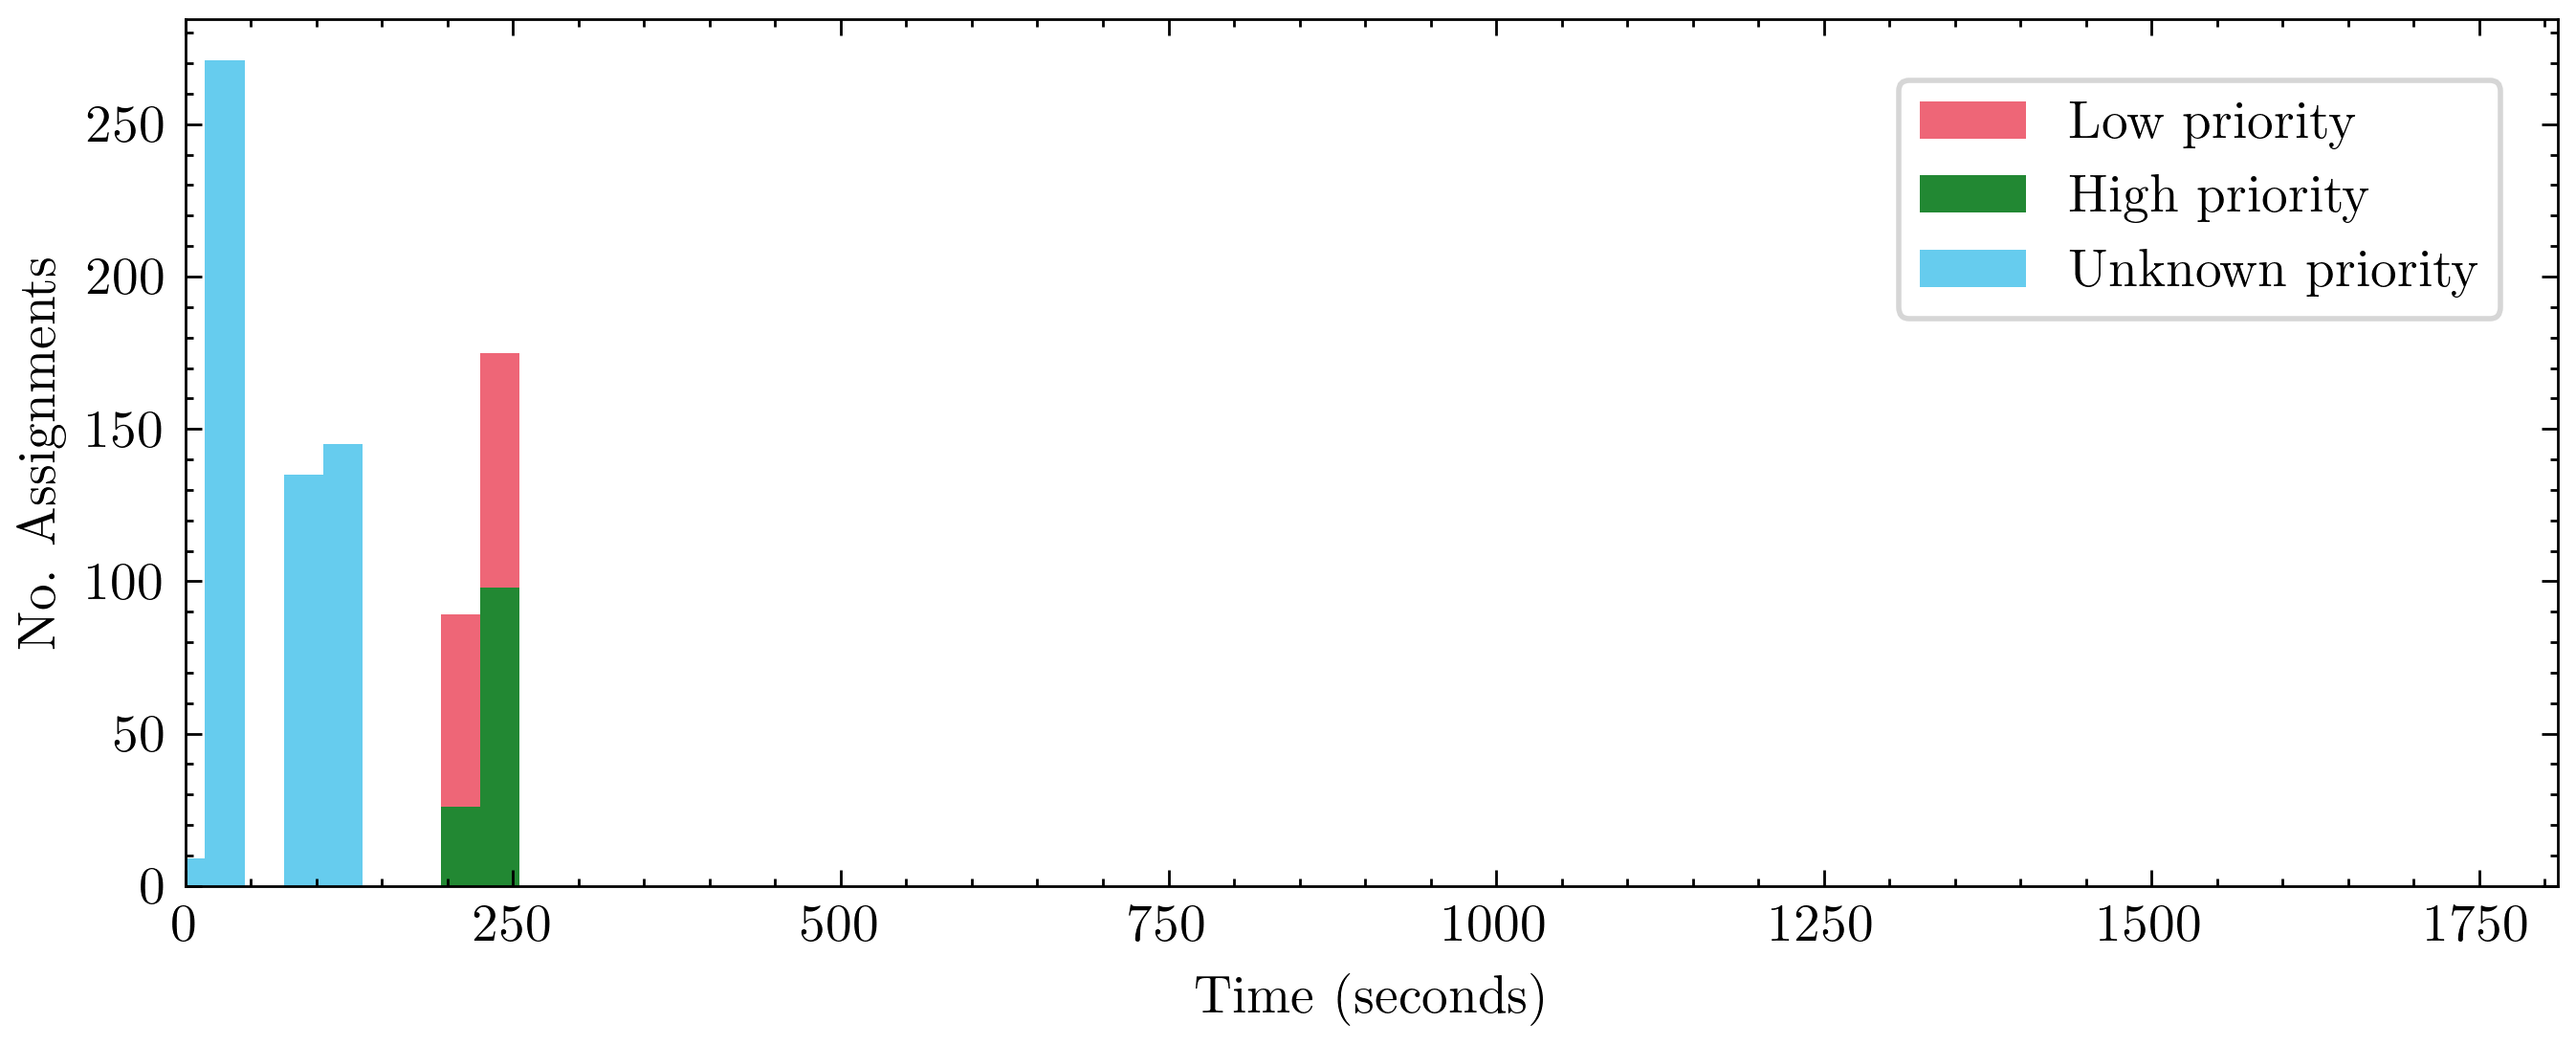

In [13]:
profile_assignments_csv = "data/constant_load_repeats_profiling_profile_assignments_2021-05-12-15-32_chronograf_data.csv"
out = "../out/profiling_dimming_without_component_weightings_profiles.pdf"

df = pd.read_csv(profile_assignments_csv)[["_time", "_value", "session_id"]]
df["elapsed"] = (
    pd.to_datetime(df["_time"].values) - pd.to_datetime(df["_time"][0])
).total_seconds()
df_low = df[df["_value"] == "low"]
df_high = df[df["_value"] == "high"]
df_unknown = df[df["_value"] == "unknown"]

plt.rcParams["figure.figsize"] = [8, 3]
plt.rcParams["figure.dpi"] = 400

fig, ax1 = plt.subplots()

ax1.set_xlabel("Time (seconds)")
ax1.set_ylabel("No. Assignments")
line1 = ax1.bar(df_low["elapsed"].values, df_low["session_id"].values, color="#ee6677", width=30)
line2 = ax1.bar(df_high["elapsed"].values, df_high["session_id"].values, color="#228833", width=30)
line3 = ax1.bar(df_unknown["elapsed"].values, df_unknown["session_id"].values, color="#66ccee", width=30)
ax1.set_xlim([0, 1810])

fig.legend(
    ["Low priority", "High priority", "Unknown priority"],
    frameon=True,
    loc="upper right",
    bbox_to_anchor=(0.89, 0.85),
)
plt.savefig(out)

## Profiling dimming (edge case = low/news)

p95 mean:  2.934586216826316
p95 stdev:  0.608367441673477
pid output mean:  9.716762859176274
pid output stdev:  3.6726329537820894


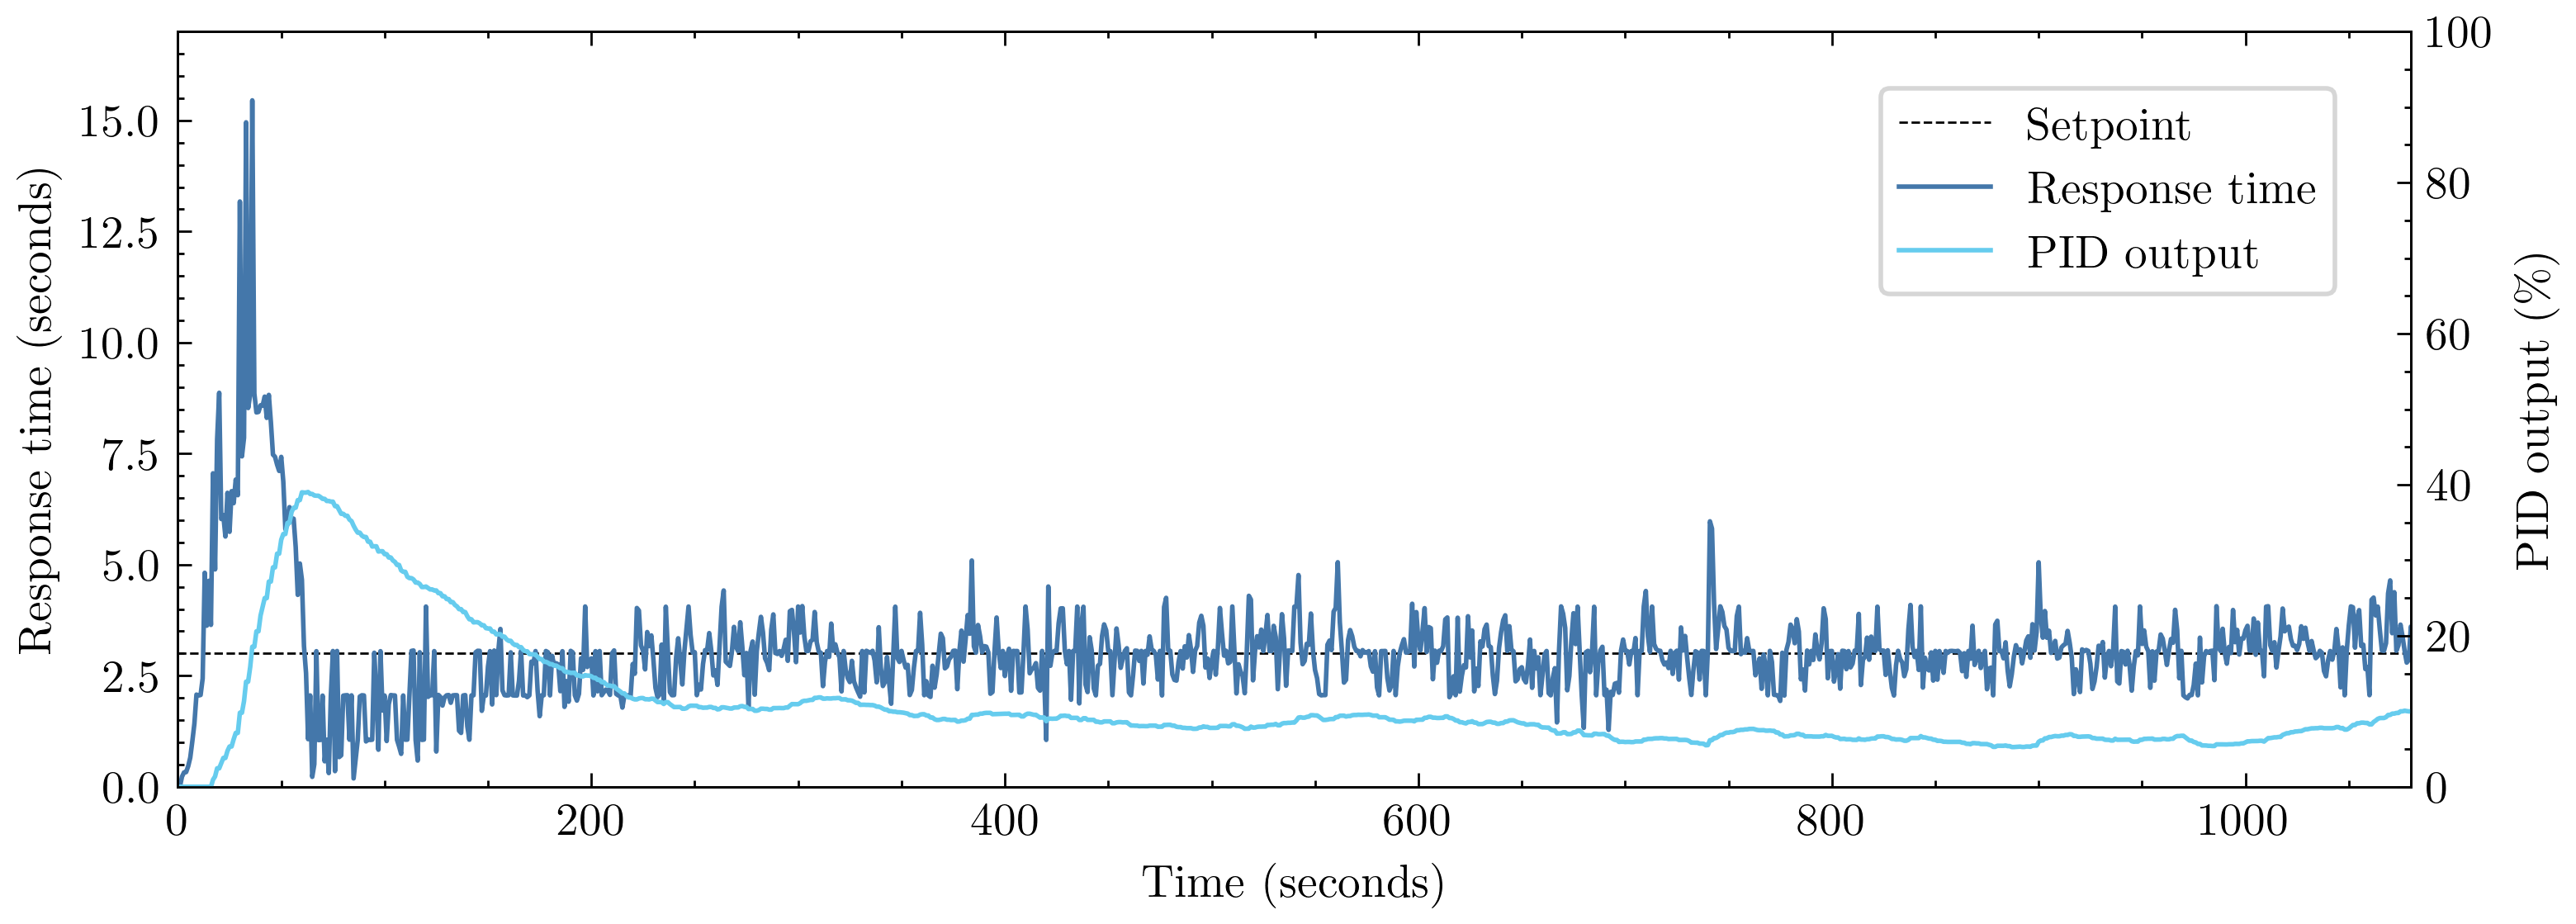

In [14]:
p95_csv = "data/profiling_all_low_edge_case_response_time_and_pid_output_2021-05-17-14-12_chronograf_data.csv"
pid_csv = "data/profiling_all_low_edge_case_response_time_and_pid_output_2021-05-17-14-12_chronograf_data.csv"
out = "../out/profiling_edge_case_low.pdf"

df_on_p95 = read_p95_csv(p95_csv)
df_on_pid = read_pid_csv(pid_csv)

print_stats(df_on_p95, df_on_pid)
plot_p95_pid_graph(df_on_p95, df_on_pid, ylim=17)
plt.savefig(out)

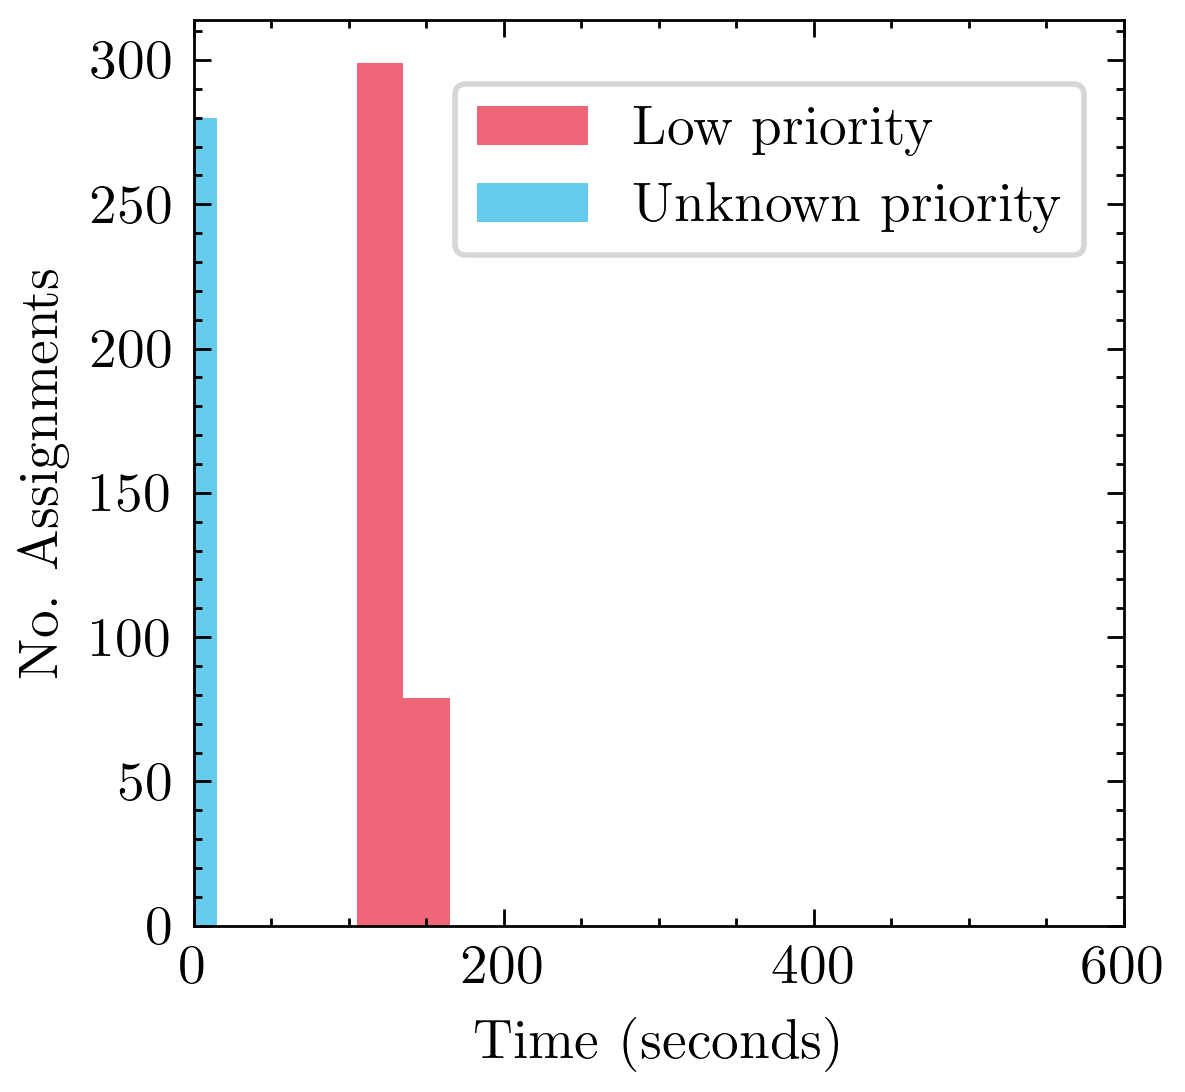

In [15]:
priority_assignments_csv = "data/profiling_all_low_edge_case_priority_assignments_2021-05-17-14-12_chronograf_data.csv"
out = "../out/profiling_edge_case_low_priorities.pdf"

df = pd.read_csv(priority_assignments_csv)[["_time", "_value", "session_id"]]
add_elapsed_column(df)
df_low = df[df["_value"] == "low"]
df_unknown = df[df["_value"] == "unknown"]

plt.rcParams["figure.figsize"] = [3, 3]
plt.rcParams["figure.dpi"] = 400

fig, ax1 = plt.subplots()

ax1.set_xlabel("Time (seconds)")
ax1.set_ylabel("No. Assignments")
ax1.set_xlim([0, 600])

line1 = ax1.bar(df_low["elapsed"].values, df_low["session_id"].values, color="#ee6677", width=30)
line2 = ax1.bar(df_unknown["elapsed"].values, df_unknown["session_id"].values, color="#66ccee", width=30)

fig.legend(
    ["Low priority", "Unknown priority"],
    frameon=True,
    loc="upper right",
    bbox_to_anchor=(0.89, 0.85),
)
plt.savefig(out)

## Profiling dimming (edge case = high/buying)

p95 mean:  3.0843691897146197
p95 stdev:  1.0151979157670834
pid output mean:  71.53652877640096
pid output stdev:  7.643327236226293


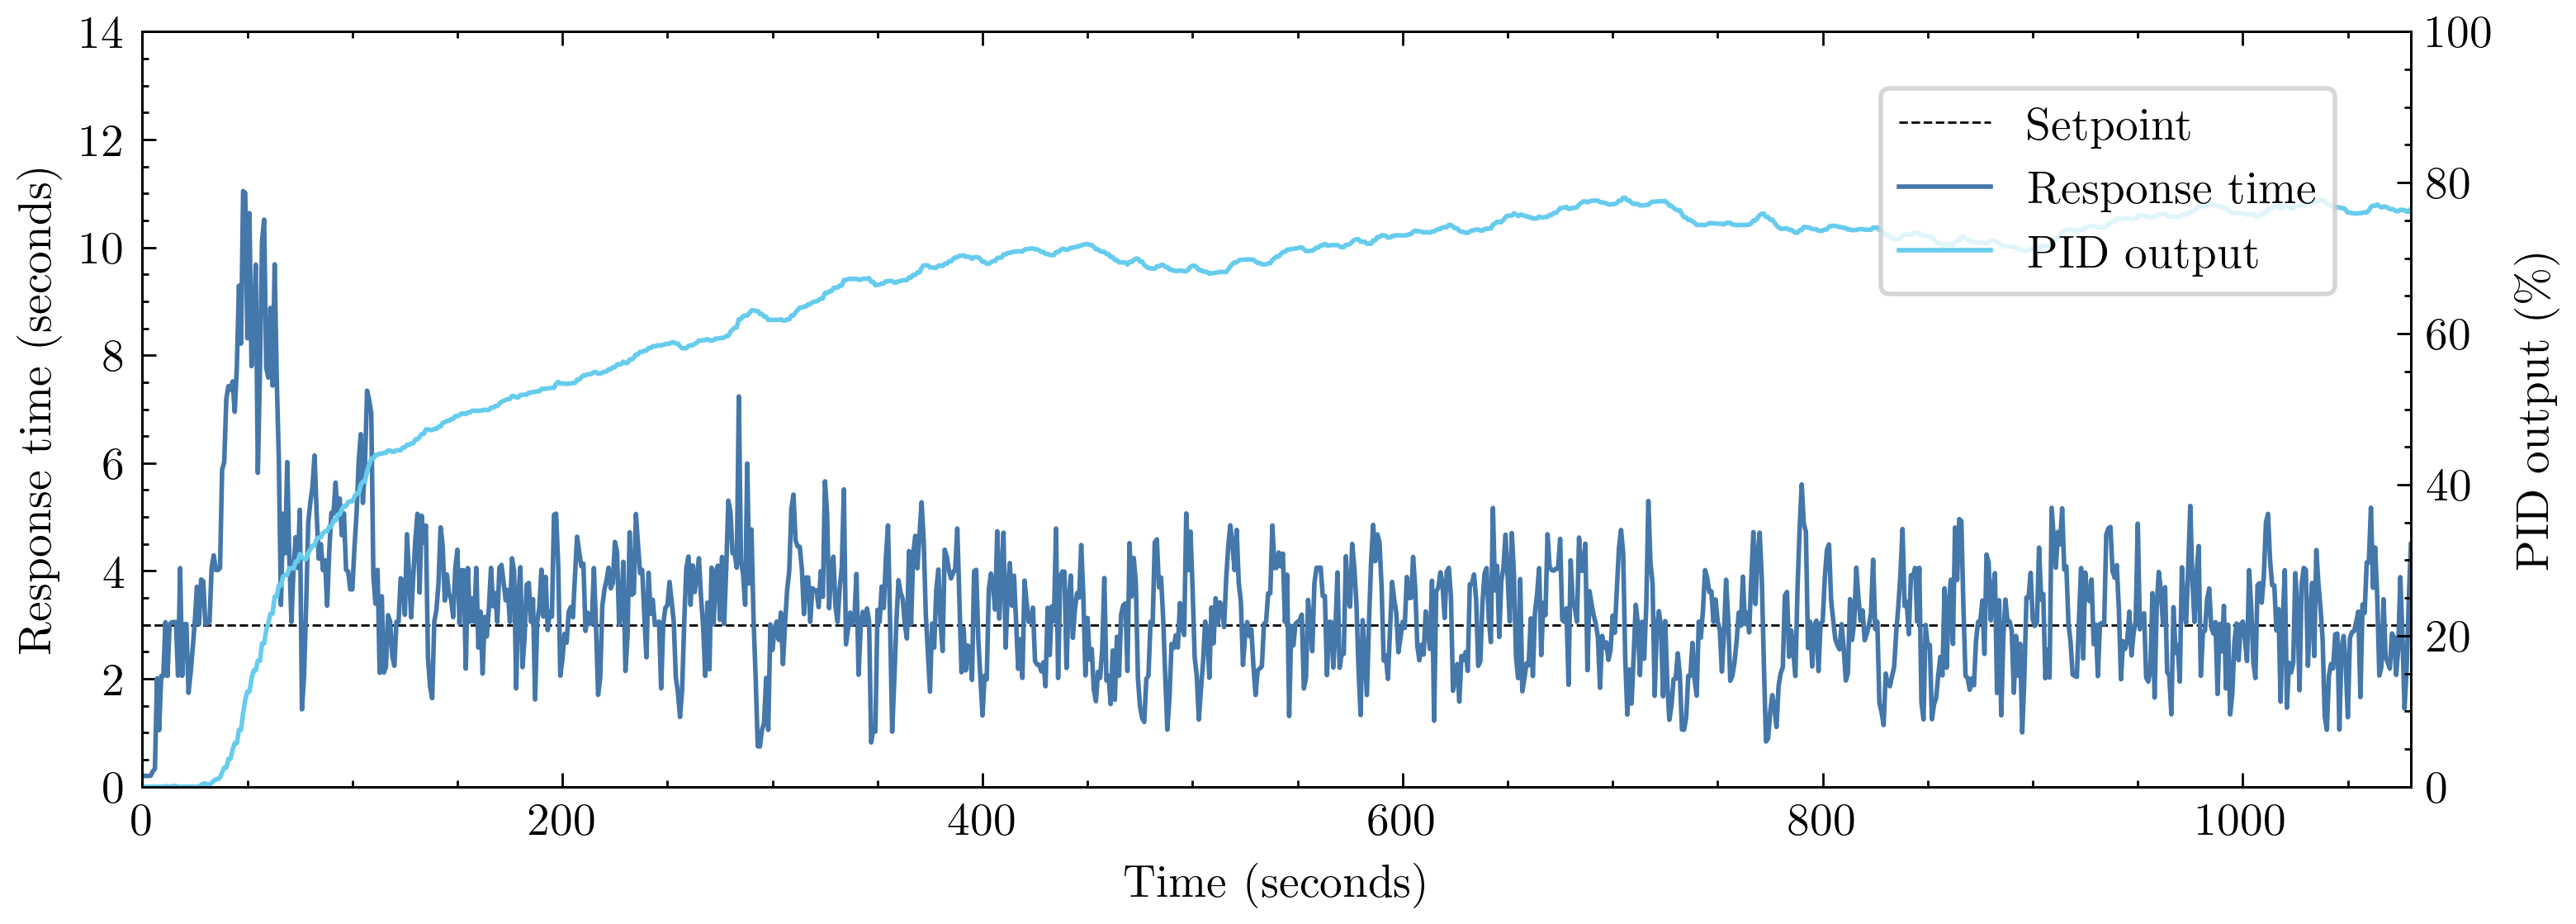

In [16]:
p95_csv = "data/profiling_all_high_edge_case_response_time_and_pid_output_2021-05-17-17-20_chronograf_data.csv"
pid_csv = "data/profiling_all_high_edge_case_response_time_and_pid_output_2021-05-17-17-20_chronograf_data.csv"
out = "../out/profiling_edge_case_high.pdf"

df_on_p95 = read_p95_csv(p95_csv)
df_on_pid = read_pid_csv(pid_csv)

print_stats(df_on_p95, df_on_pid)
plot_p95_pid_graph(df_on_p95, df_on_pid, ylim=14)
plt.savefig(out)

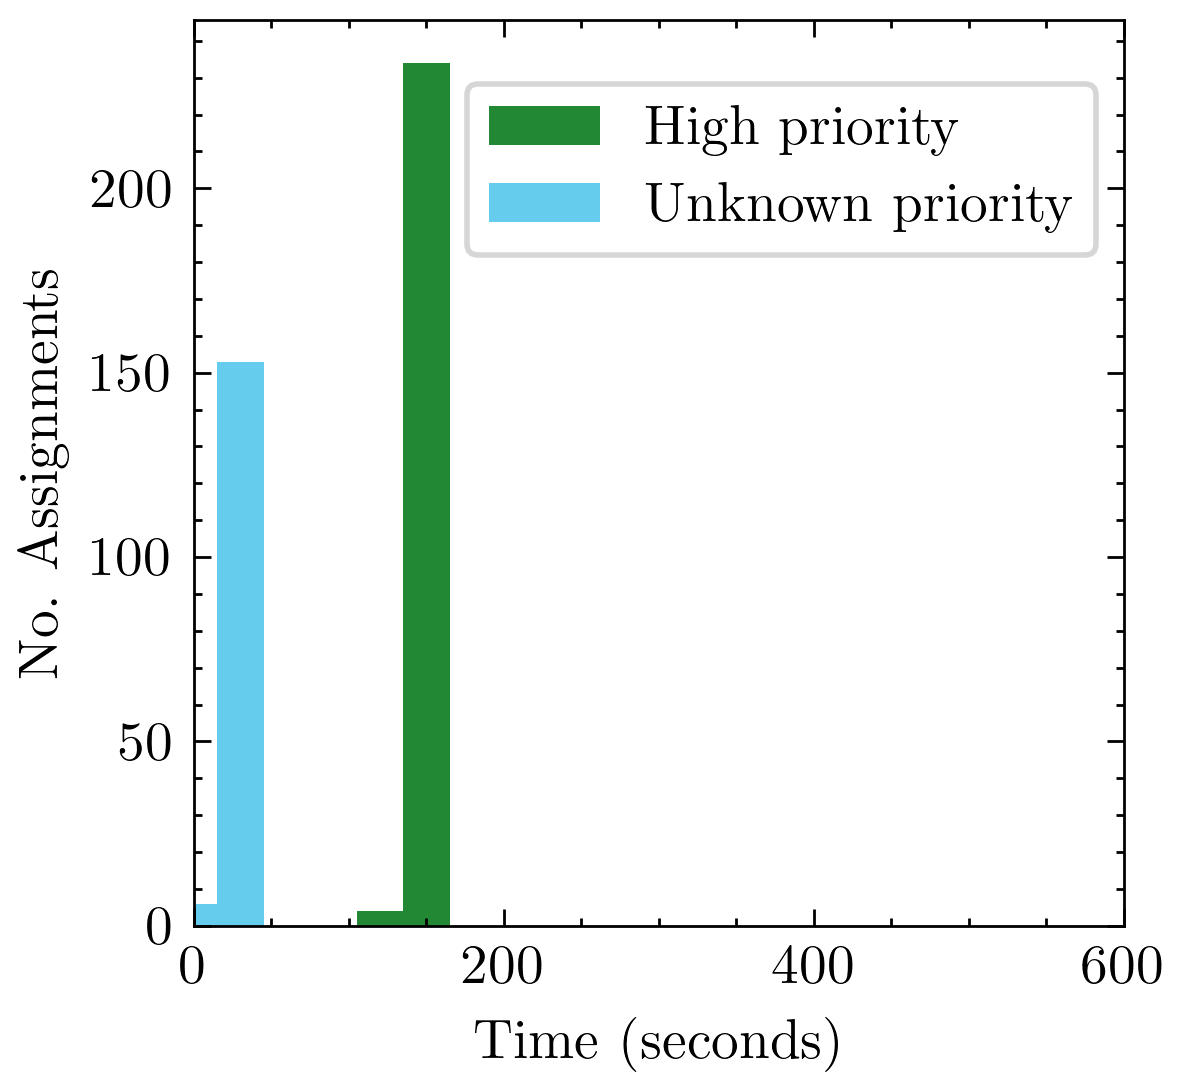

In [17]:
priority_assignments_csv = "data/profiling_all_high_edge_case_priority_assignments_2021-05-17-17-20_chronograf_data.csv"
out = "../out/profiling_edge_case_high_priorities.pdf"

df = pd.read_csv(priority_assignments_csv)[["_time", "_value", "session_id"]]
add_elapsed_column(df)
df_high = df[df["_value"] == "high"]
df_unknown = df[df["_value"] == "unknown"]

plt.rcParams["figure.figsize"] = [3, 3]
plt.rcParams["figure.dpi"] = 400

fig, ax1 = plt.subplots()
ax1.set_xlabel("Time (seconds)")
ax1.set_ylabel("No. Assignments")
ax1.set_xlim([0, 600])

line1 = ax1.bar(df_high["elapsed"].values, df_high["session_id"].values, color="#228833", width=30)
line2 = ax1.bar(df_unknown["elapsed"].values, df_unknown["session_id"].values, color="#66ccee", width=30)

fig.legend(
    ["High priority", "Unknown priority"],
    frameon=True,
    loc="upper right",
    bbox_to_anchor=(0.90, 0.85),
)
plt.savefig(out)

## Attempt at combining profiling edge cases into one graph

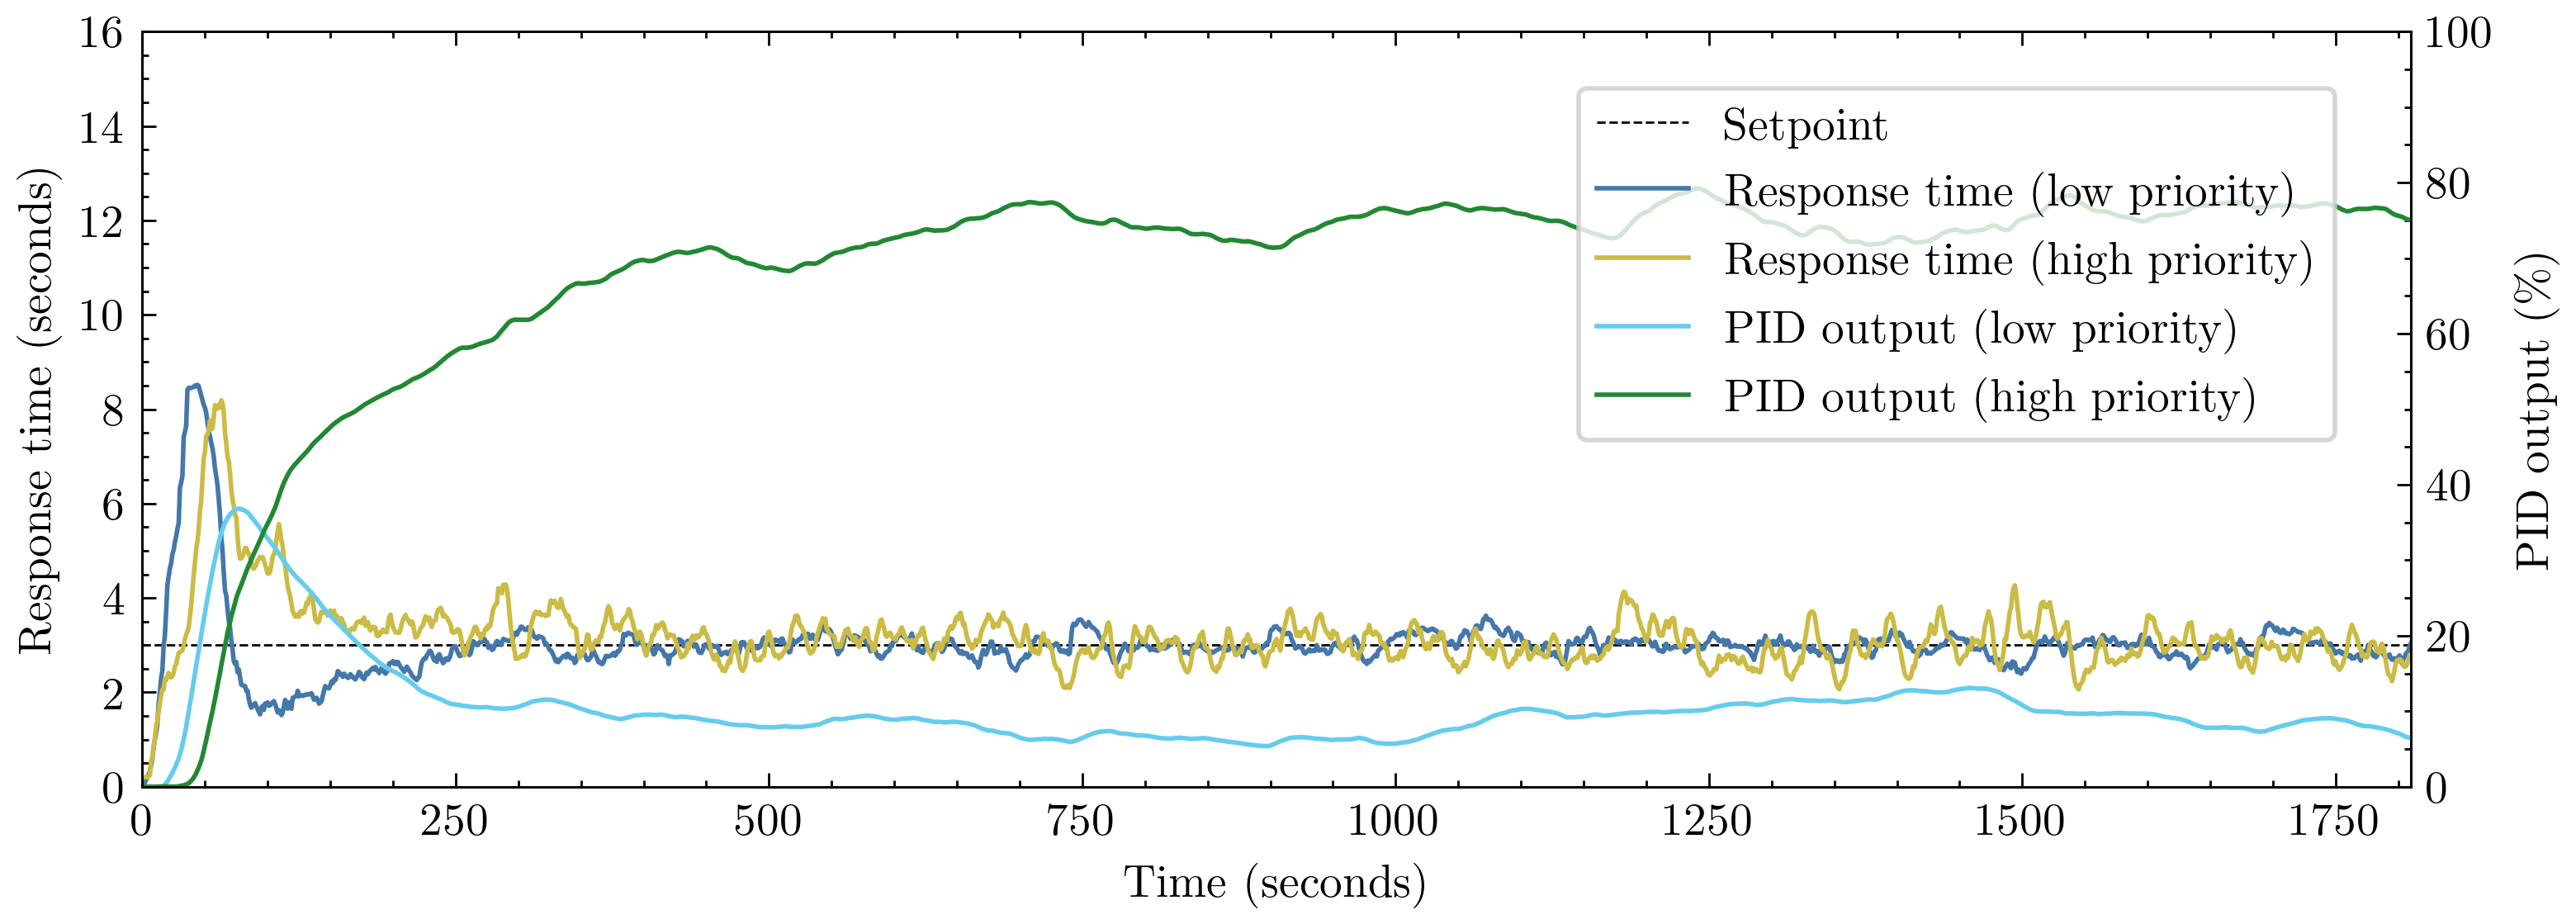

In [18]:
low_p95_csv = "data/profiling_all_low_edge_case_response_time_and_pid_output_2021-05-17-14-12_chronograf_data.csv"
low_pid_csv = "data/profiling_all_low_edge_case_response_time_and_pid_output_2021-05-17-14-12_chronograf_data.csv"
high_p95_csv = "data/profiling_all_high_edge_case_response_time_and_pid_output_2021-05-17-17-20_chronograf_data.csv"
high_pid_csv = "data/profiling_all_high_edge_case_response_time_and_pid_output_2021-05-17-17-20_chronograf_data.csv"
out = "../out/profiling_edge_case.pdf"

df_on_p95_low = read_p95_csv(low_p95_csv)
df_on_pid_low = read_pid_csv(low_pid_csv)
df_on_p95_high = read_p95_csv(high_p95_csv)
df_on_pid_high = read_pid_csv(high_pid_csv)

ax1, ax2, fig = scaffold_p95_pid_graph(1810, 16, [8, 3], 400)

line1 = ax1.plot(
    df_on_p95_low["elapsed"].values,
    df_on_p95_low["_value"].ewm(span=20).mean().values,
    color="#4477AA",
)
line2 = ax1.plot(
    df_on_p95_high["elapsed"].values,
    df_on_p95_high["_value"].ewm(span=20).mean().values,
    color="#CCBB44",
)
line3 = ax2.plot(
    df_on_pid_low["elapsed"].values,
    df_on_pid_low["_value"].ewm(span=20).mean().values,
    color="#66CCEE",
)
line4 = ax2.plot(
    df_on_pid_high["elapsed"].values,
    df_on_pid_high["_value"].ewm(span=20).mean().values,
    color="#228833",
)

fig.legend(
    [
        "Setpoint",
        "Response time (low priority)",
        "Response time (high priority)",
        "PID output (low priority)",
        "PID output (high priority)",
    ],
    frameon=True,
    loc="upper right",
    bbox_to_anchor=(0.905, 0.9),
)
plt.savefig(out)

## Profiling dimming (with component weightings)

p95 mean:  2.9952254397163744
p95 stdev:  0.7534011140692799
pid output mean:  44.05687129554149
pid output stdev:  2.567740429686985


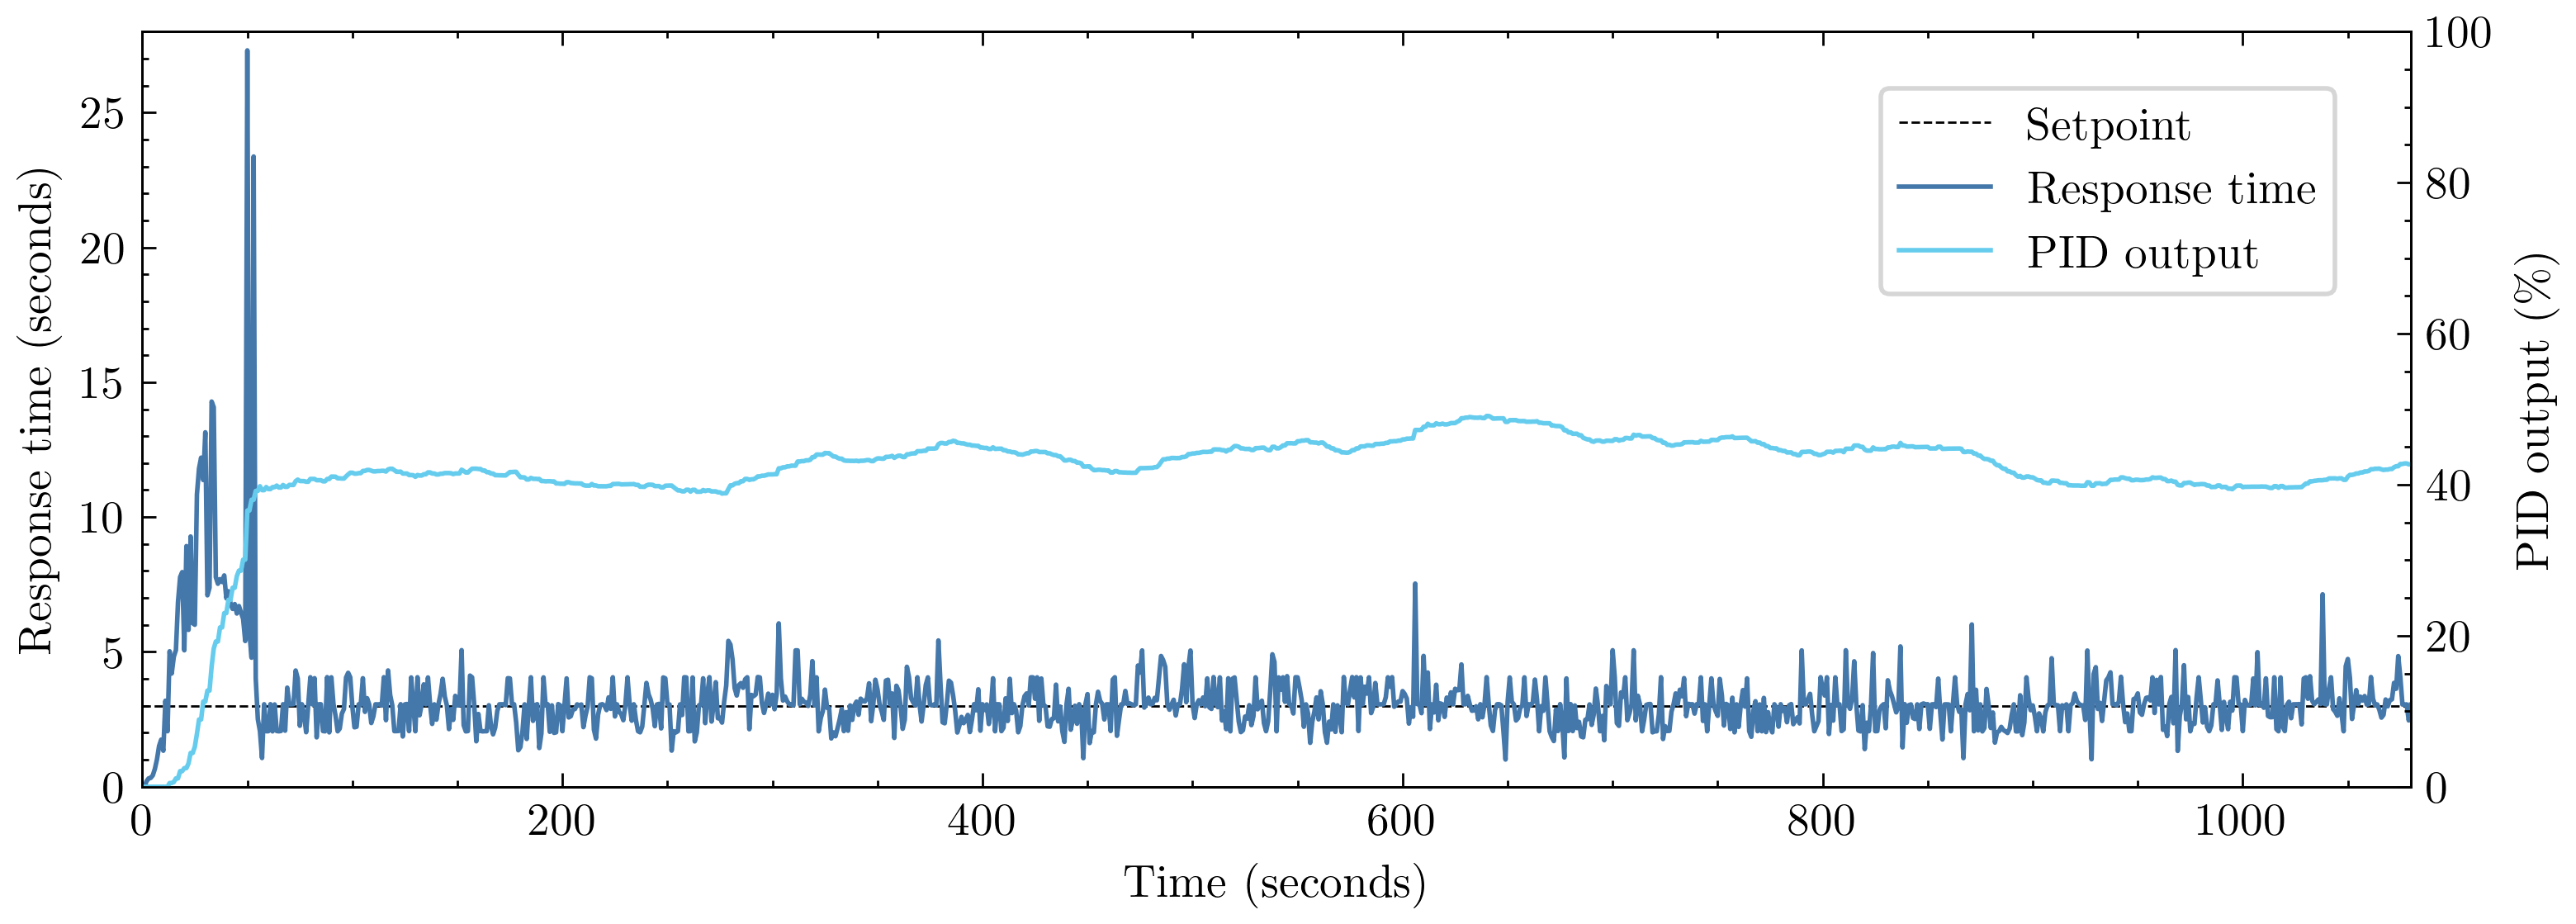

In [19]:
p95_csv = "data/constant_load_repeats_profiling_with_component_weightings_2021-05-14-17-11_chronograf_data.csv"
pid_csv = "data/constant_load_repeats_profiling_with_component_weightings_2021-05-14-17-11_chronograf_data.csv"
out = "../out/profiling_dimming_with_component_weightings.pdf"

df_on_p95 = read_p95_csv(p95_csv)
df_on_pid = read_pid_csv(pid_csv)

print_stats(df_on_p95, df_on_pid)
plot_p95_pid_graph(df_on_p95, df_on_pid, ylim=28)
plt.savefig(out)


# Developer Usability

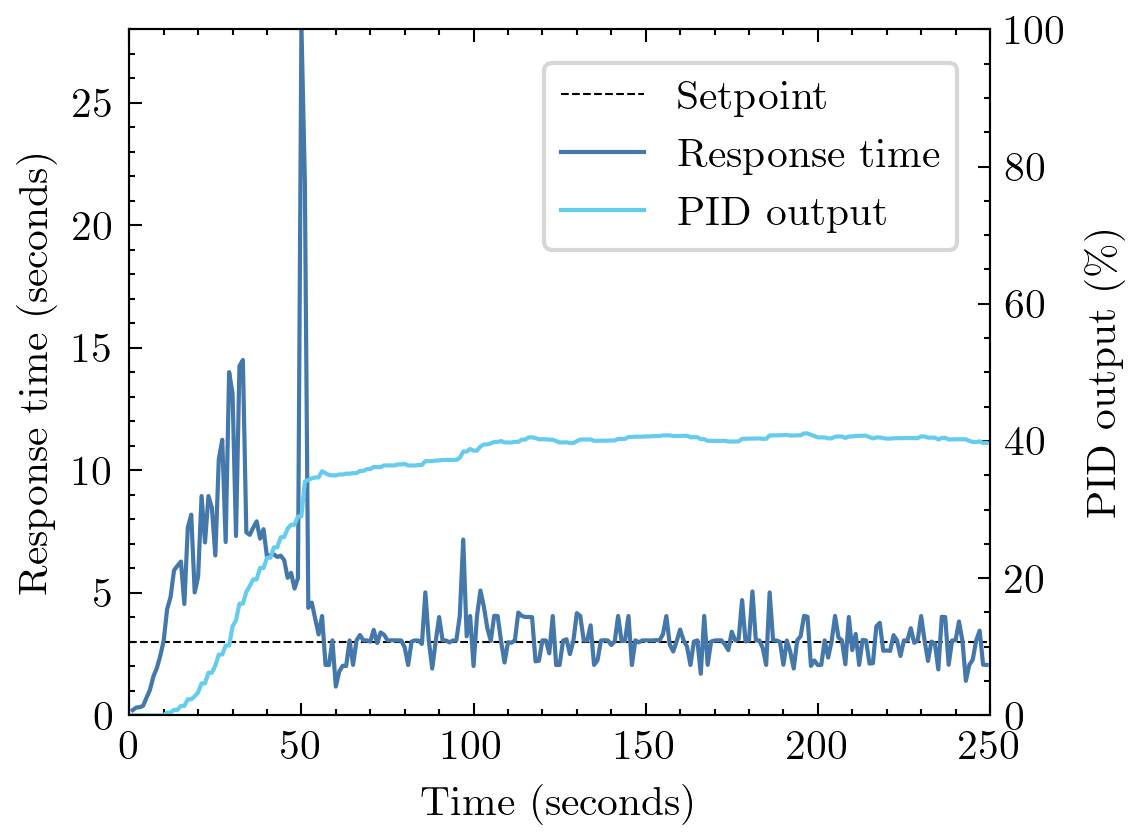

In [20]:
csv = "data/developer_usability_baseline_2021-05-19-14-13_chronograf_data.csv"
out = "../out/developer_usability_baseline.pdf"

df_on_p95 = remove_spikes(read_p95_csv(csv))
df_on_pid = read_pid_csv(csv)

plot_p95_pid_graph(df_on_p95, df_on_pid, xlim=250, ylim=28, legend_bbox=(0.84, 0.92), figsize=[4,3], dpi=300)
plt.savefig(out)

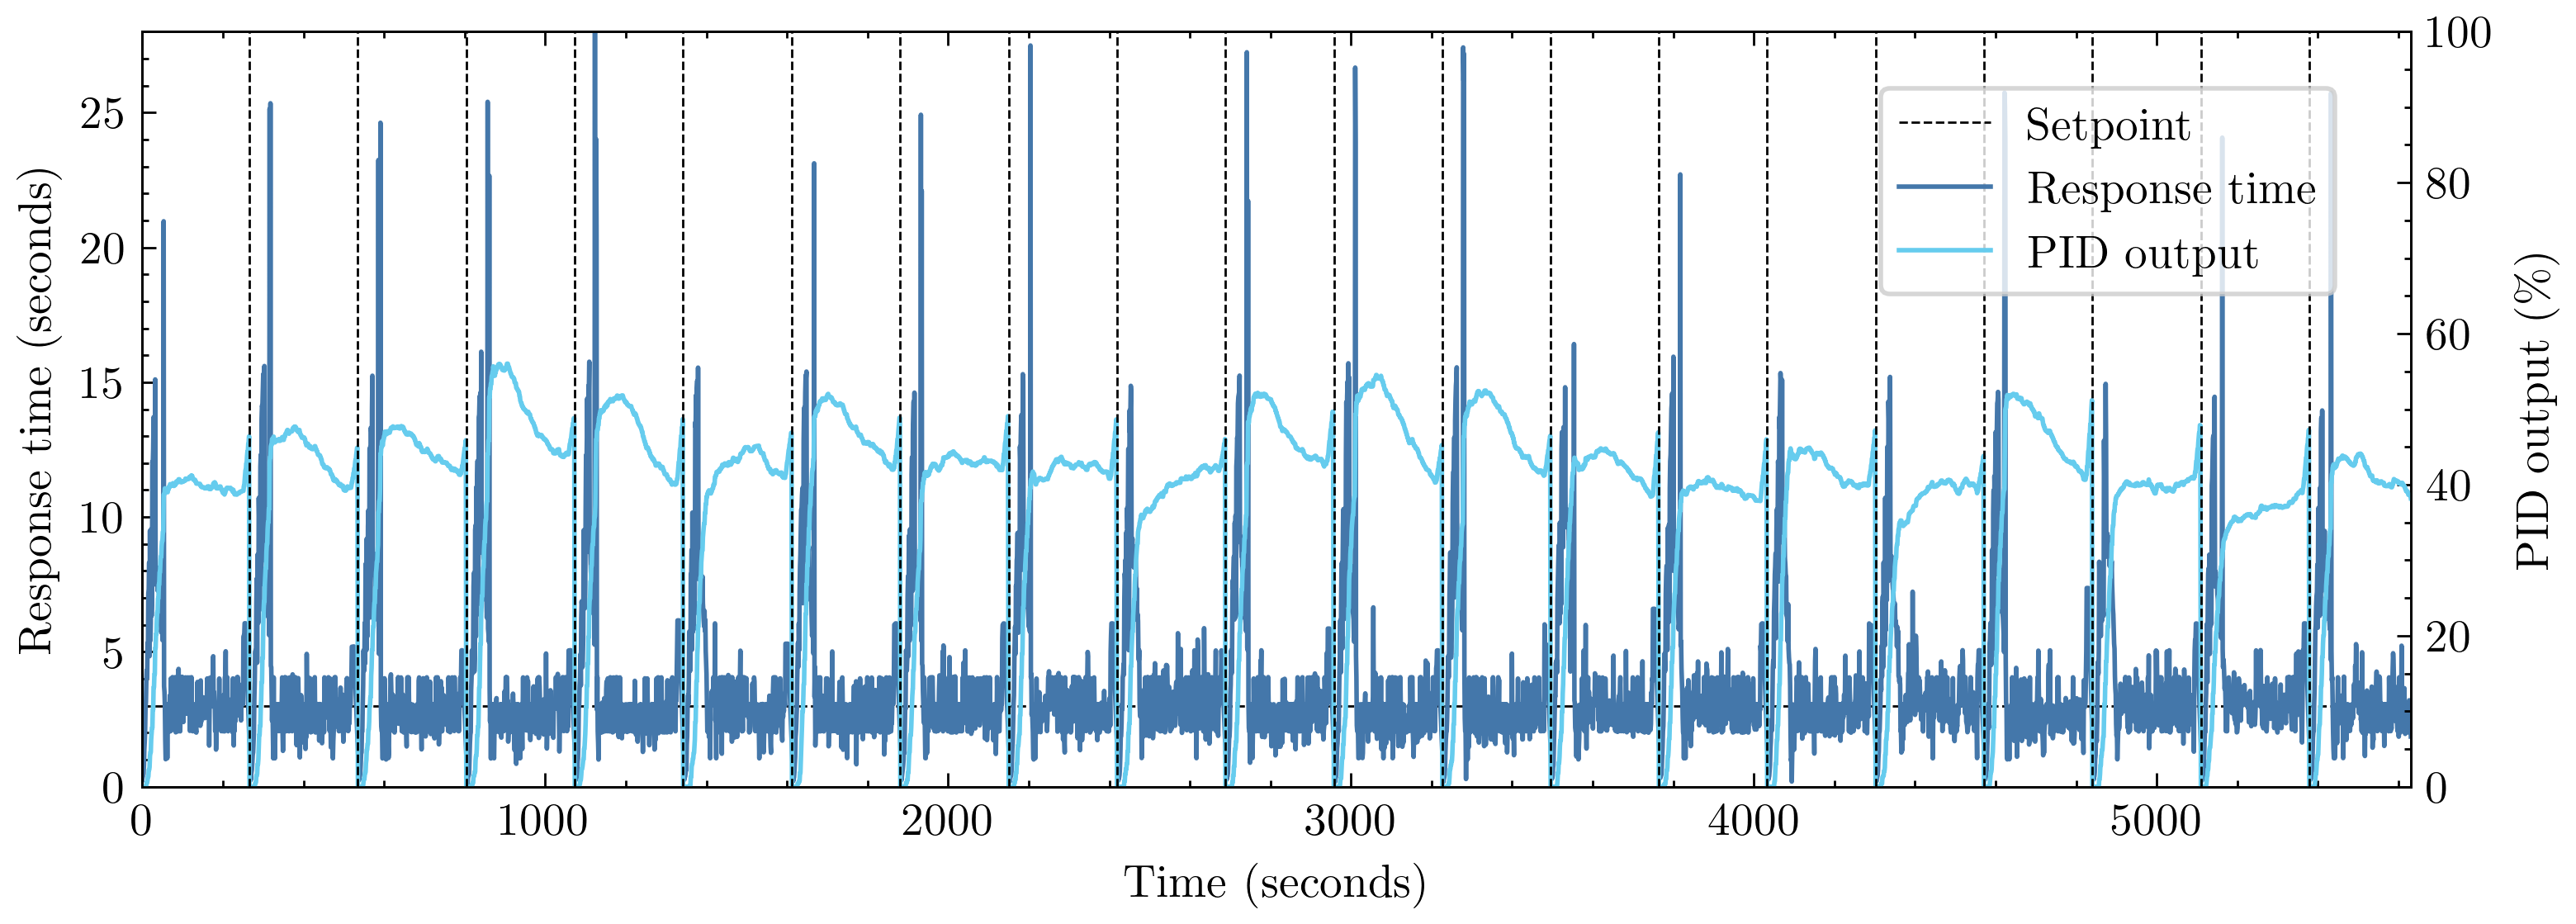

In [21]:
csv = "data/developer_usability_recommender_2021-05-19-14-14_chronograf_data.csv"
out = "../out/developer_usability_recommender.pdf"

df_on_p95 = remove_spikes(read_p95_csv(csv))
df_on_pid = read_pid_csv(csv)

plot_p95_pid_graph(df_on_p95, df_on_pid, xlim=df_on_p95["elapsed"].max(), ylim=28)
plot_dotted_verticals(experiment_start_points(df_on_pid))

plt.savefig(out)

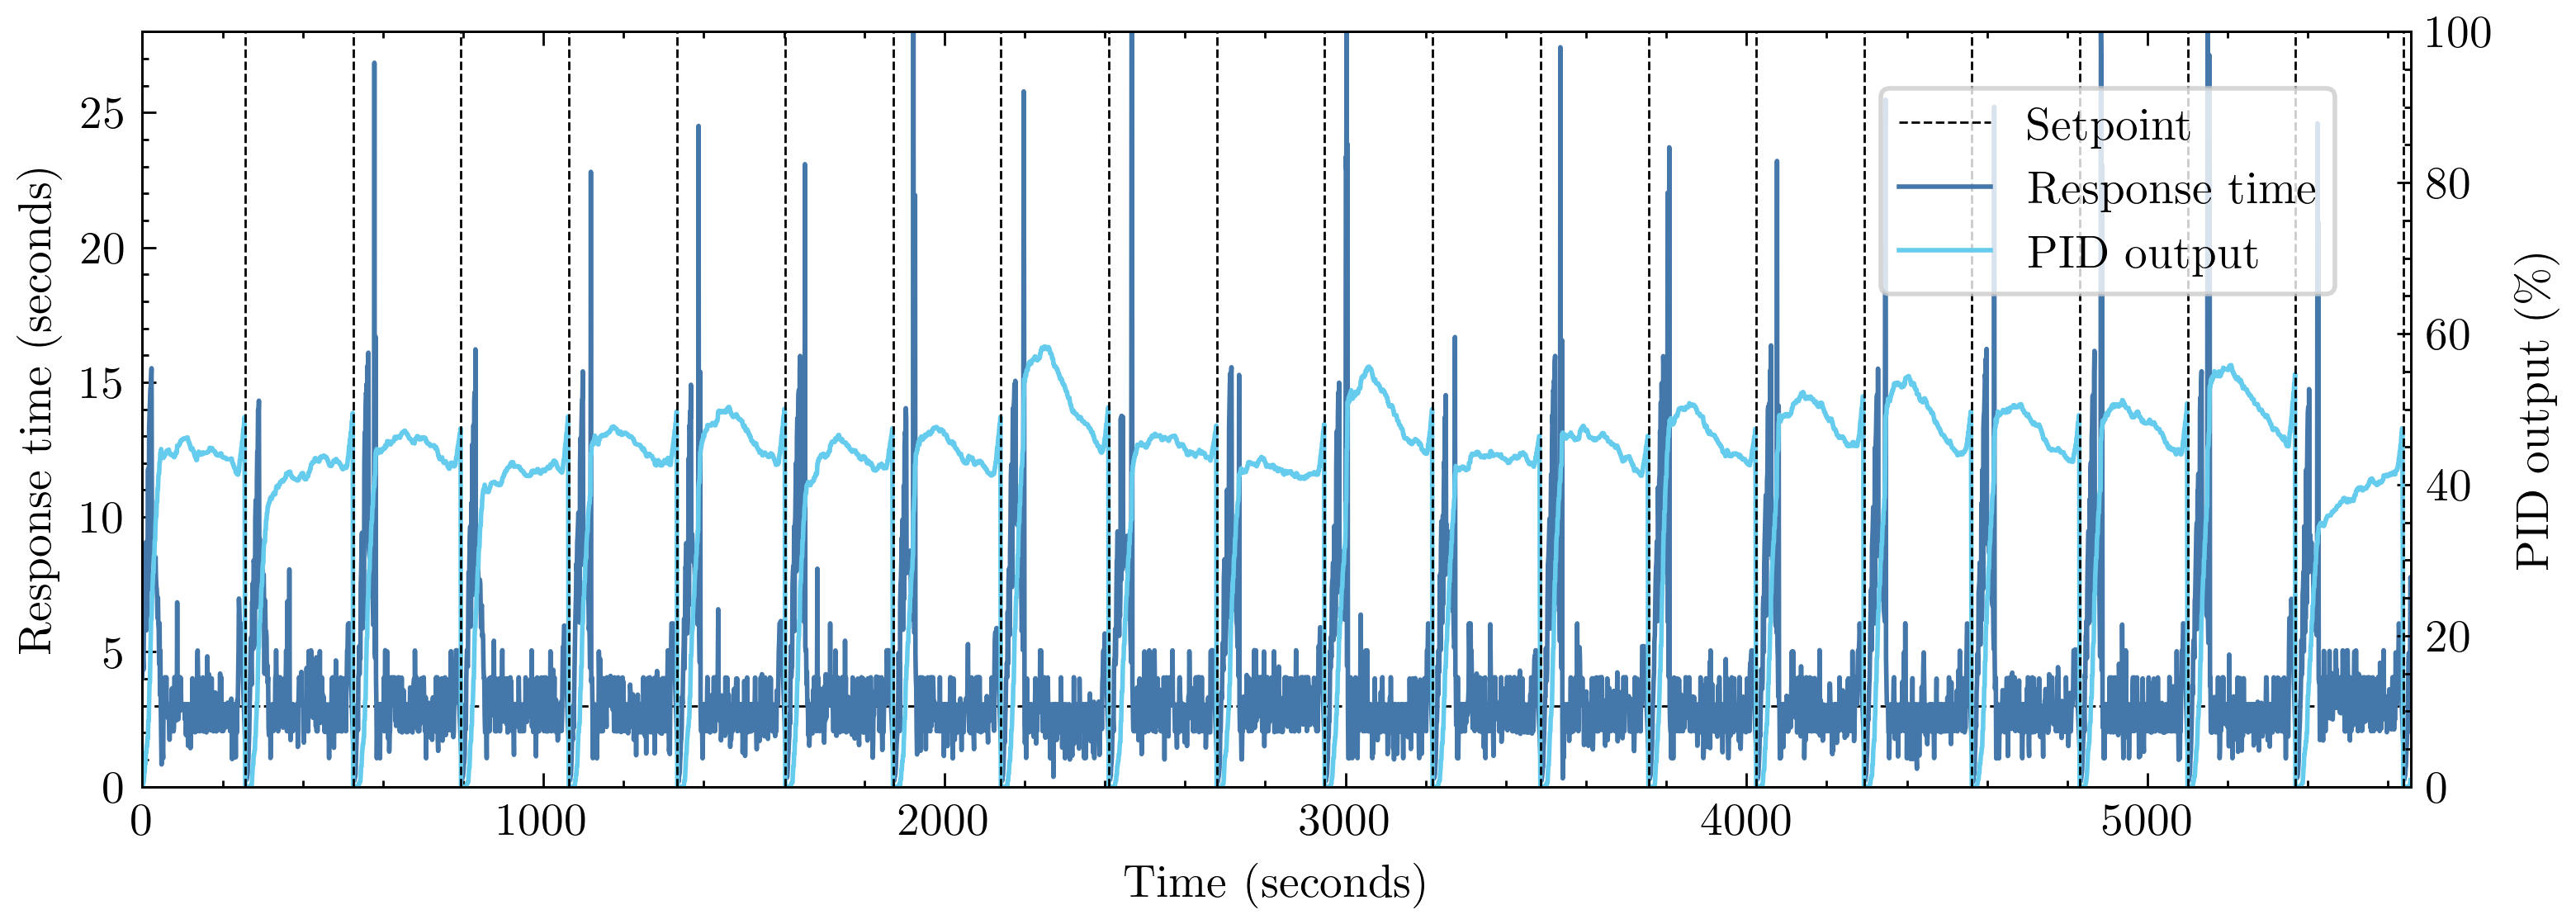

In [22]:
csv = "data/developer_usability_news_2021-05-19-14-21_chronograf_data.csv"
out = "../out/developer_usability_news.pdf"

df_on_p95 = remove_spikes(read_p95_csv(csv))
df_on_pid = read_pid_csv(csv)

plot_p95_pid_graph(df_on_p95, df_on_pid, xlim=df_on_p95["elapsed"].max(), ylim=28)
plot_dotted_verticals(experiment_start_points(df_on_pid))

plt.savefig(out)

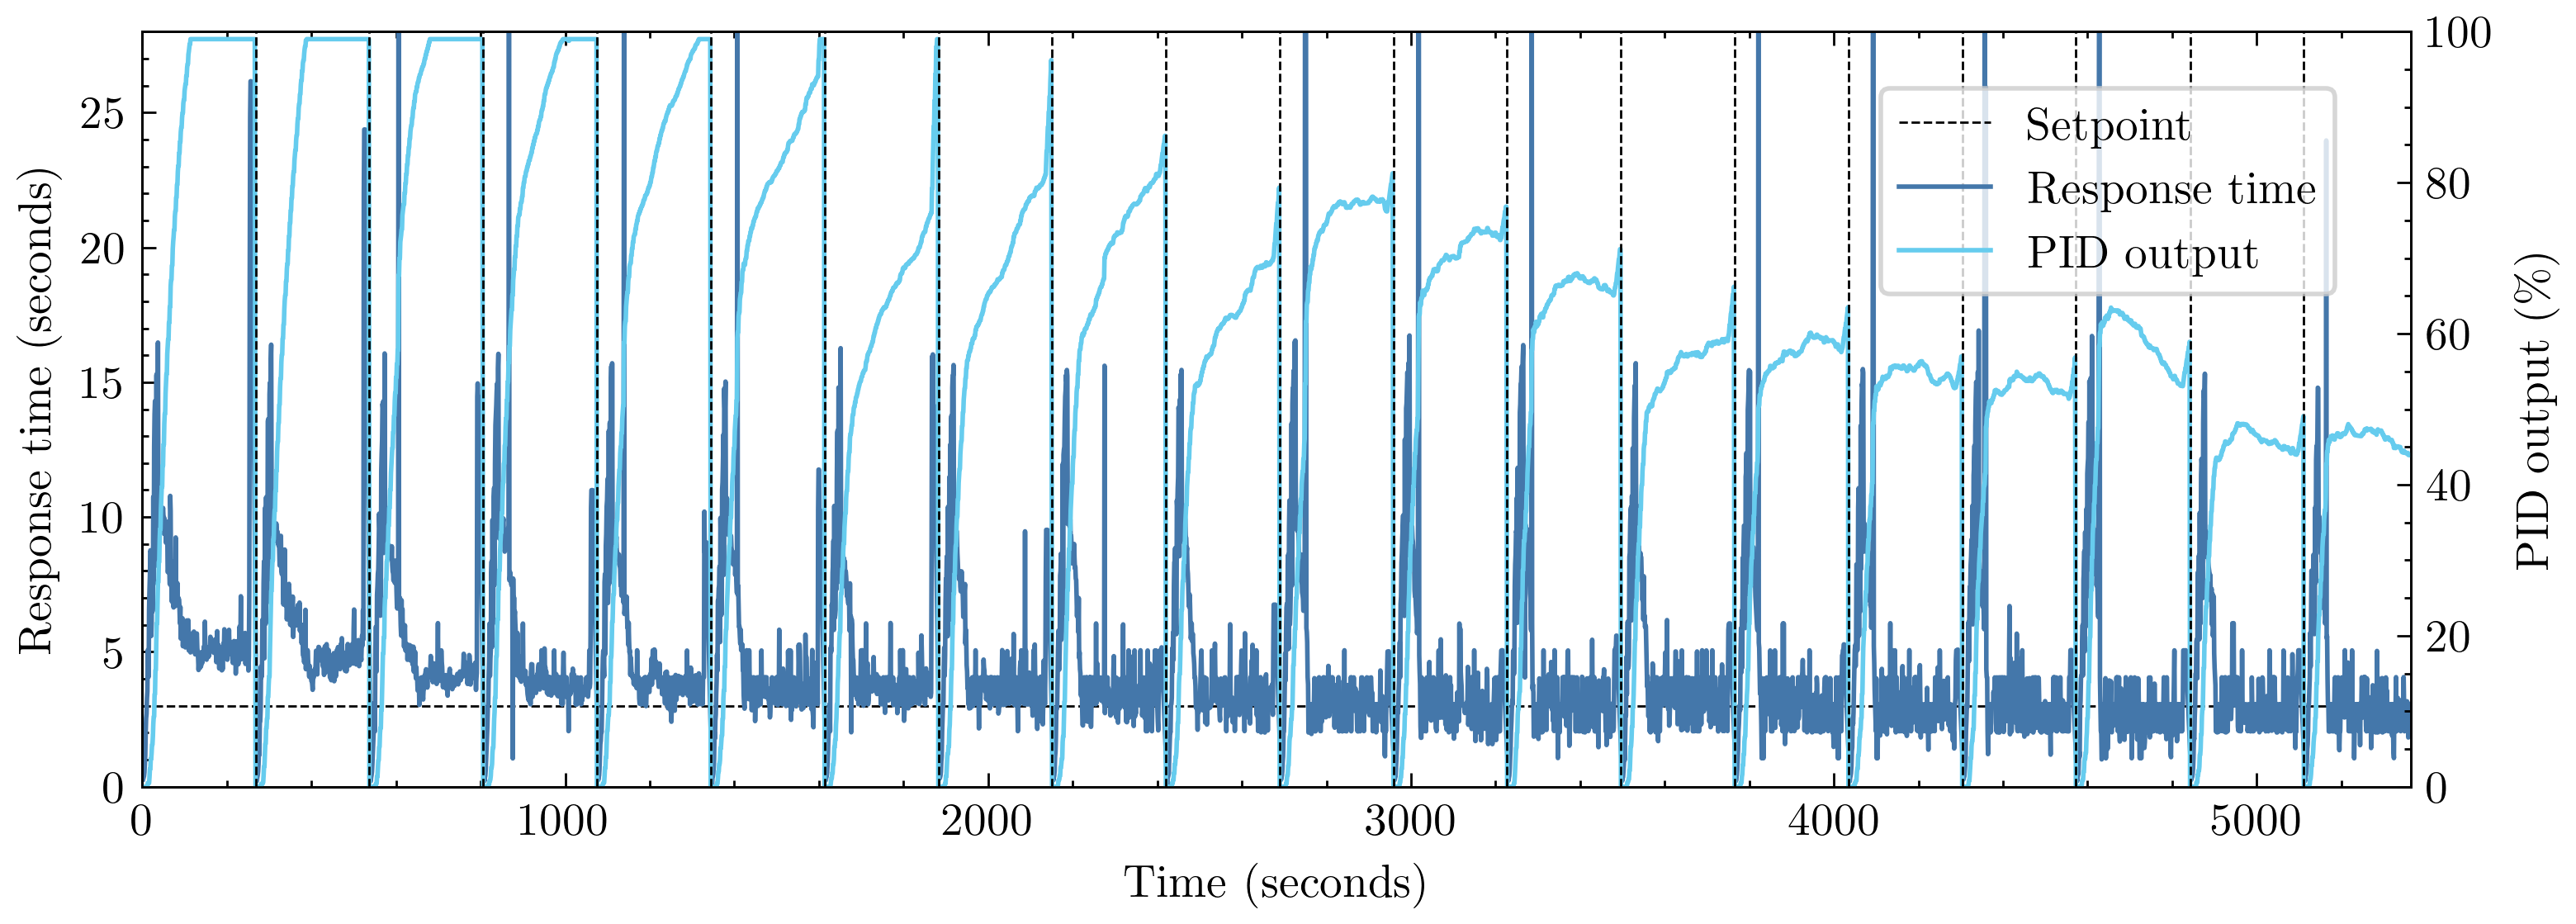

In [23]:
csv = "data/developer_usability_cart_2021-05-19-14-29_chronograf_data.csv"
out = "../out/developer_usability_cart.pdf"

df_on_p95 = remove_spikes(read_p95_csv(csv))
df_on_pid = read_pid_csv(csv)

plot_p95_pid_graph(df_on_p95, df_on_pid, xlim=df_on_p95["elapsed"].max(), ylim=28)
plot_dotted_verticals(experiment_start_points(df_on_pid))

plt.savefig(out)